In [49]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [50]:
# Data Collection 4.1
## Read S and P 500 list
import pandas as pd
import numpy as np
dfsp500 = pd.read_csv('data/SANDP500.csv')
companies=dfsp500['Symbol'].to_list()  # Updated from tolist() to to_list()
companies=np.random.choice(companies, size=500, replace=False)

In [51]:
import glob
import os
path = r"R:\Documents_all\book_1sem\assignment\DA\projectDA\netsci-project\data\NASDAQ"                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NAS = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NAS=concatenated_df_NAS[concatenated_df_NAS['<ticker>'].isin(companies)]

path = r"R:\Documents_all\book_1sem\assignment\DA\projectDA\netsci-project\data\NYSE"                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NYS = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NYS=concatenated_df_NYS[concatenated_df_NYS['<ticker>'].isin(companies)]

concatenated_df = pd.concat([concatenated_df_NAS,concatenated_df_NYS])

In [52]:
col_p = 'close'  # Fixed typo from ol_p to col_p
concatenated_df.columns = ['ticker','date','open','high','low','close','vol']
concatenated_df=concatenated_df[concatenated_df['ticker'].isin(companies)]
concatenated_df=concatenated_df.merge(dfsp500,left_on='ticker',right_on='Symbol')
concatenated_df['ticker'] = concatenated_df['ticker']
df_price = concatenated_df[['ticker','date',col_p]]
df_price=df_price.drop_duplicates(keep='last')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
df_price.set_index(['date','ticker'],inplace=True)
df_price=df_price.unstack()[col_p]
df_price.reset_index(inplace=True)
df_price.fillna(method='bfill',inplace=True)
df_price.fillna(method='ffill',inplace=True)

C:\Users\rames\AppData\Local\Temp\ipykernel_23288\3038070541.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
C:\Users\rames\AppData\Local\Temp\ipykernel_23288\3038070541.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price.fillna(method='bfill',inplace=True)
C:\Users\rames\AppData\Local\Temp\ipykernel_23288\3038070541.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price.fillna(method='ffill',inplace=True)


In [53]:
# 4.2 Detrend Data
import scipy.signal
t = 1
for key in df_price.columns:
    if key not in companies:
        continue
    try:
        df_price[key] = np.log(df_price[key]) - np.log(df_price[key].shift(t))
    except:
        print(key)
df_price.set_index('date',inplace=True)

In [ ]:
# %matplotlib qt

## A quick visualization: detrended data
import matplotlib.pyplot as plt
# %matplotlib inline#
import random as rn
NUM_COLORS = len(companies)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i/NUM_COLORS) for i in range(NUM_COLORS)]
rn.seed = len(companies)  # for choosing random colors
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y=2007
for row in ax:
    for col in row:
        yfs = str(y) + '0101'
        yfe = str(y) + '1231'
        n = 0
        col.set_ylim([0.5, -0.5])
        for i in df_price.columns:
            df_price.loc[yfs:yfe][i].plot(ax=col,color=colors[n])
            n = n + 1
        y = y + 1
plt.tight_layout()
plt.show()

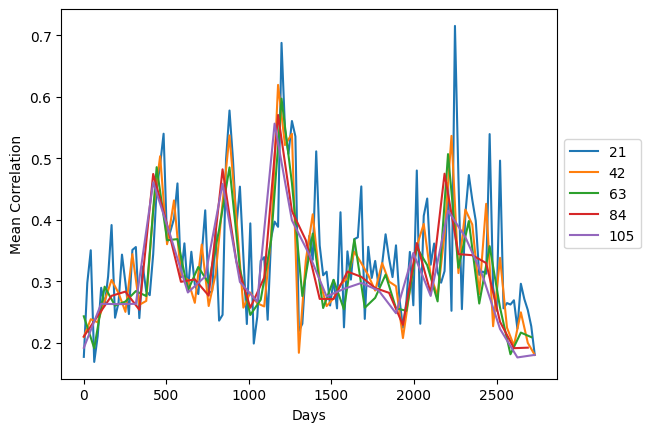

In [ ]:
# 4.3 Compute Correlation Matrix For Multiple Windows
import matplotlib.pyplot as plt
%matplotlib inline
corr_dict = {}
T = 1
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(0,inplace=True)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Correlation')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.show()
W = 63
corr_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(0,inplace=True)

In [ ]:
# 4.4 Build Network 
import networkx as nx
import community.community_louvain as community  # Updated import
def get_modularity(y,threshold):
    df_price_corr = corr_dict[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():    
            if abs(outdict[i][j]) > threshold:
                if i == j:
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W)])
                else:
                    None
    G=nx.Graph()
    G.add_edges_from(elist)
    partition = community.best_partition(G)  # Updated community detection
    try:
        m = community.modularity(partition, G)  # Updated modularity calculation
    except:
        m = 0 
    return m

fractions = np.linspace(0.6, 0.99, 20)
M_list = {}
for y in corr_dict.keys():
    M_list[y] = [get_modularity(y, frac) for frac in fractions]

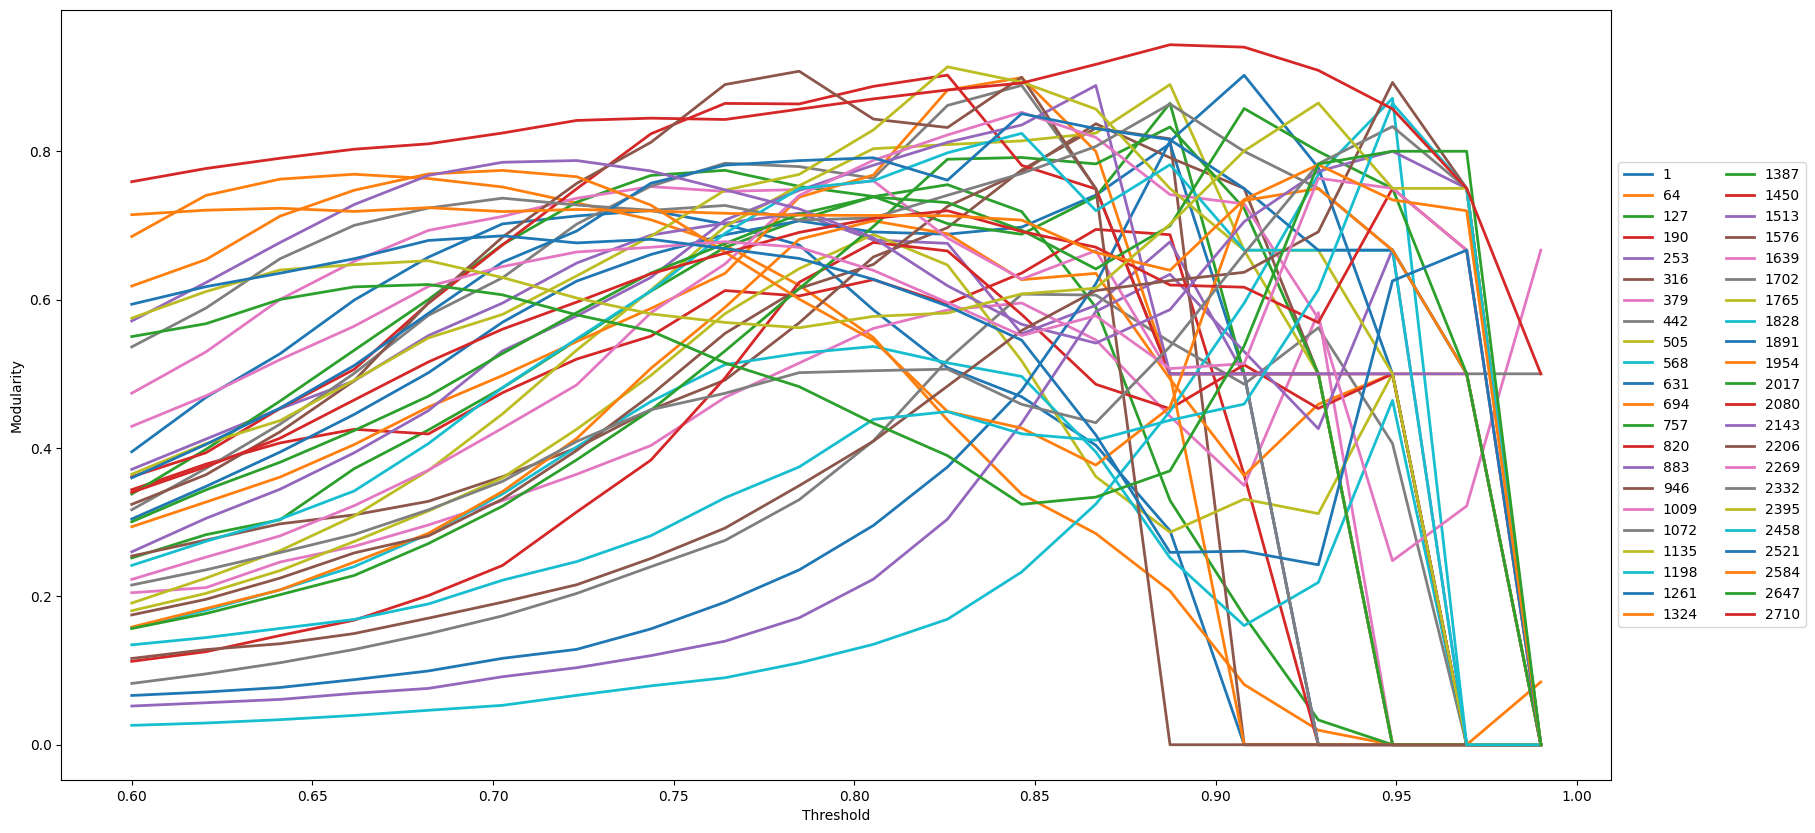

In [ ]:
#the plot between the threshold value and the computed markdown in the various windows
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
for y in corr_dict.keys():
    plt.plot(fractions, M_list[y], lw=2)
plt.legend(list(M_list.keys()), loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
plt.xlabel('Threshold')
plt.ylabel('Modularity')
plt.show()

In [ ]:
# Pick value of threshold for each Window (T)
T_val = {}
for y in M_list.keys():
    val, idx = max((val, idx) for (idx, val) in enumerate(M_list[y]))
    if fractions[idx] > 0.8:
        T_val[y] = 0.8
    else:
        T_val[y] = fractions[idx]
    #print (str(y) + ":" + str(T_val[y]))

In [ ]:
# Create Edge List
elist_dict={}
for y in corr_dict.keys():
    df_price_corr = corr_dict[y]
    threshold = T_val[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if abs(outdict[i][j]) > threshold:
                if i == j:
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=1,start=y,end=y+W-1)])
                else:
                    None
    elist_dict[y] = elist

In [ ]:
# Constructing the graph different windows
import networkx as nx
import community.community_louvain as community  # Updated import
G_dict = {}
for y in elist_dict.keys():
    G=nx.Graph()
    elist = elist_dict[y]
    G.add_edges_from(elist)
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            # Updated node attribute setting
            G.nodes[node]['Sector'] = value
        except:
            None
    
    partition = community.best_partition(G)
    
    deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(G).items())
    degree = dict((k,float(v)) for k,v in G.degree())
    close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(G).items())  
    betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(G).items()) 
    
    nx.set_node_attributes(G, partition, "community")  
    nx.set_node_attributes(G, deg_cent, "degreecent")
    nx.set_node_attributes(G, degree, "degree")
    nx.set_node_attributes(G, close_cent, "closeness")
    nx.set_node_attributes(G, betw_cent, "betweenness")
    nx.set_node_attributes(G, y, 'start')
    nx.set_node_attributes(G, y+W-1, 'end')
    
    T = G
    G_dict[y] = T

In [ ]:
# Collect the node level attributes for the nodes for all the windows
df_list = []
for k in G_dict.keys():
    G = G_dict[k]
    a = {n: G.nodes[n] for n in G.nodes()}  # Updated node attribute access
    df_list.append(pd.DataFrame(a).T.reset_index())
attrib_df = pd.concat(df_list)
attrib_df.fillna(0,inplace=True)
attrib_df1=attrib_df.merge(dfsp500,left_on='index',right_on='Symbol')
attrib_df = attrib_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
attrib_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

In [ ]:
# Collect the graph level attributes for all the windows
from scipy.stats import linregress
G_val_dict = {}
for Y in G_dict.keys():
    G_val = {}
    G = G_dict[Y]
    G_val['nodes'] = int(G.number_of_nodes())
    G_val['edges'] = int(G.number_of_edges())
    G_val['AvgClustering'] = nx.average_clustering(G)
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    degs = {}
    for n in G.nodes():
        deg = G.degree(n)
        if deg not in degs.keys():
            degs[deg] = 0
        degs[deg] += 1
    items = sorted(degs.items())
    x = [k for (k, v) in items]
    y = [v for (k, v) in items]
    xlog = np.array([np.log(k) for (k, v) in items])
    ylog = np.array([np.log(v) for (k, v) in items])
    slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
    G_val['Slope'] = slope
    G_val['No of Communities'] = attrib_df.groupby(by=['start'])['Community'].nunique().loc[Y]  # Updated loc usage
    G_val_dict[Y] = G_val
Gvaldf=pd.DataFrame(G_val_dict).T

In [ ]:
pd.options.display.max_rows = 999
Gvaldf

nodes    edges  AvgClustering  AvgShortestPathLength  Diameter  \
1     141.0    484.0       0.457861           99999.000000   99999.0   
64    184.0    915.0       0.570144           99999.000000   99999.0   
127   114.0    339.0       0.557172           99999.000000   99999.0   
190    86.0    239.0       0.467189           99999.000000   99999.0   
253   151.0    397.0       0.349009           99999.000000   99999.0   
316   122.0    275.0       0.348793           99999.000000   99999.0   
379   176.0    818.0       0.478426           99999.000000   99999.0   
442   345.0   3853.0       0.502469           99999.000000   99999.0   
505   195.0    698.0       0.438182           99999.000000   99999.0   
568   217.0   1136.0       0.424498           99999.000000   99999.0   
631   121.0    305.0       0.403202           99999.000000   99999.0   
694   111.0    267.0       0.485234           99999.000000   99999.0   
757    84.0    150.0       0.368077           99999.000000   99999.0   
820   175.0    480.0       0.384052           99999.000000   99999.0   
883   308.0   6228.0       0.618020           99999.000000   99999.0   
946   109.0    226.0       0.347166           99999.000000   99999.0   
1009   37.0     33.0       0.111712           99999.000000   99999.0   
1072   64.0     59.0       0.128993           99999.000000   99999.0   
1135  177.0    391.0       0.380433           99999.000000   99999.0   
1198  410.0  22805.0       0.729352               1.894043       5.0   
1261  271.0   3044.0       0.599090           99999.000000   99999.0   
1324   61.0     62.0       0.156648           99999.000000   99999.0   
1387  174.0    482.0       0.380184           99999.000000   99999.0   
1450   53.0     42.0       0.155975           99999.000000   99999.0   
1513   74.0     83.0       0.242707           99999.000000   99999.0   
1576   57.0     35.0       0.050292           99999.000000   99999.0   
1639  167.0    318.0       0.376223           99999.000000   99999.0   
1702   75.0    144.0       0.431398           99999.000000   99999.0   
1765   73.0     70.0       0.247489           99999.000000   99999.0   
1828   75.0    106.0       0.302684           99999.000000   99999.0   
1891   79.0    105.0       0.321146           99999.000000   99999.0   
1954  240.0    751.0       0.457399           99999.000000   99999.0   
2017  208.0    539.0       0.348167           99999.000000   99999.0   
2080  190.0    765.0       0.518887           99999.000000   99999.0   
2143  121.0    259.0       0.315658           99999.000000   99999.0   
2206  344.0   3358.0       0.540373           99999.000000   99999.0   
2269  181.0    575.0       0.449595           99999.000000   99999.0   
2332  226.0    603.0       0.316691           99999.000000   99999.0   
2395  139.0    521.0       0.475658           99999.000000   99999.0   
2458  246.0   1460.0       0.465133           99999.000000   99999.0   
2521  315.0   1385.0       0.450793           99999.000000   99999.0   
2584  113.0    330.0       0.477173           99999.000000   99999.0   
2647  111.0    372.0       0.456096           99999.000000   99999.0   
2710  191.0    297.0       0.341851           99999.000000   99999.0   

         Slope  No of Communities  
1    -0.805698               17.0  
64   -0.604598               20.0  
127  -1.047659               15.0  
190  -0.952205               16.0  
253  -1.204563               21.0  
316  -1.129906               20.0  
379  -0.901211               23.0  
442  -0.842085               11.0  
505  -1.020942               22.0  
568  -0.918342               21.0  
631  -1.126496               18.0  
694  -1.079574               20.0  
757  -1.154507               14.0  
820  -1.131862               20.0  
883  -0.502489               15.0  
946  -1.276005               17.0  
1009 -1.735520               11.0  
1072 -1.509773               22.0  
1135 -1.295920               23.0  
1198 -0.197859                4.0  
1261 -0.7

C:\Users\rames\AppData\Local\Temp\ipykernel_23288\3283021577.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
C:\Users\rames\AppData\Local\Temp\ipykernel_23288\3283021577.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)


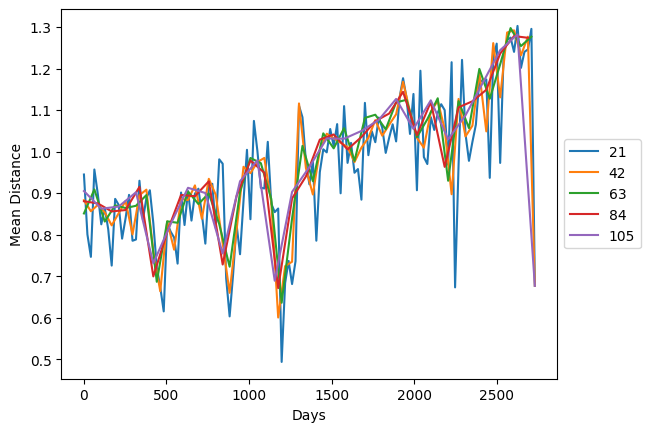

In [ ]:
#4.5 Build Network Build network - Minimum Spanning Tree  Method
import math
import matplotlib.pyplot as plt
%matplotlib inline
def calc_d(x):
    x = round(x,3)
    d = math.sqrt(2 * (1 - x))
    return d
corr_dict = {}
corr_dist_dict = {}
T = 1
W = 63
x = []
y = []
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(1,inplace=True)
            corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dist_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Distance')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
W = 63
corr_dict = {}
corr_dist_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(1,inplace=True)
      corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)

In [ ]:
#MST Start 
elistmst_dict={}
for y in corr_dist_dict.keys():
    df_price_corr = corr_dist_dict[y]
    elistmst = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if (abs(outdict[i][j]) > 0 and (i>j)):
                elistmst.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W-1)])
    elistmst_dict[y] = elistmst

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Initialize the clustering model with a distance threshold (adjust as needed)
distance_threshold = 0.5
agg_model = AgglomerativeClustering(linkage='average', metric='precomputed', distance_threshold=distance_threshold, n_clusters=None)
GMST_dict ={}
for y in elistmst_dict.keys():
    G = nx.Graph()
    elist = elistmst_dict[y]
    G.add_edges_from(elist)
    
    # Generate minimum spanning tree
    T = nx.minimum_spanning_tree(G)
    G = T
    
    # Set sector attribute for nodes
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        if node in G.nodes:
            G.nodes[node]['Sector'] = value

    # Create a distance (similarity) matrix for clustering
    adjacency_matrix = nx.to_numpy_array(G)
    distance_matrix = 1 - adjacency_matrix  # Convert similarity to distance for clustering
    
    # Apply Agglomerative Clustering with dynamic clusters
    partition_labels = agg_model.fit_predict(distance_matrix)
    partition = {node: int(partition_labels[i]) for i, node in enumerate(G.nodes())}

    # Calculate centralities
    deg_cent = {k: float(v) for k, v in nx.degree_centrality(G).items()}
    degree = {k: float(v) for k, v in G.degree()}
    close_cent = {k: float(v) for k, v in nx.closeness_centrality(G).items()}
    betw_cent = {k: float(v) for k, v in nx.betweenness_centrality(G).items()}
    
    # Set node attributes
    nx.set_node_attributes(G, partition, "community")  
    nx.set_node_attributes(G, deg_cent, "degreecent")
    nx.set_node_attributes(G, degree, "degree")
    nx.set_node_attributes(G, close_cent, "closeness")
    nx.set_node_attributes(G, betw_cent, "betweenness")
    nx.set_node_attributes(G, y, 'start')
    nx.set_node_attributes(G, y + W, 'end')
    
    T = G
    GMST_dict[y] = T


In [ ]:
# louvain

# import networkx as nx
# import community.community_louvain as community  # Updated import
# GMST_dict = {}
# for y in elistmst_dict.keys():
#     G=nx.Graph()
#     elist = elistmst_dict[y]
#     G.add_edges_from(elist)
#     T = nx.minimum_spanning_tree(G)
#     G = T
#     values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
#     for node, value in values.items():
#         try:
#             G.nodes[node]['Sector'] = value  # Updated node attribute setting
#         except:
#             None
            
#     partition = community.best_partition(G)
    
#     deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(G).items())
#     degree = dict((k,float(v)) for k,v in G.degree())
#     close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(G).items())  
#     betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(G).items()) 
    
#     nx.set_node_attributes(G, partition, "community")  
#     nx.set_node_attributes(G, deg_cent, "degreecent")
#     nx.set_node_attributes(G, degree, "degree")
#     nx.set_node_attributes(G, close_cent, "closeness")
#     nx.set_node_attributes(G, betw_cent, "betweenness")
#     nx.set_node_attributes(G, y, 'start')
#     nx.set_node_attributes(G, y+W, 'end')
    
#     T = G
#     GMST_dict[y] = T

In [ ]:
df_list = []
for k in GMST_dict.keys():
    G = GMST_dict[k]
    a = {n: G.nodes[n] for n in G.nodes()}  # Updated node attribute access
    df_list.append(pd.DataFrame(a).T.reset_index())
attribMST_df = pd.concat(df_list)
attribMST_df.fillna(0,inplace=True)
attribMST_df1=attribMST_df.merge(dfsp500,left_on='index',right_on='Symbol')
attribMST_df = attribMST_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
attribMST_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

In [ ]:
from scipy.stats import linregress
G_valMST_dict = {}
for Y in GMST_dict.keys():
    G_val = {}
    G= GMST_dict[Y]
    G_val['nodes'] = G.number_of_nodes()
    G_val['edges'] = G.number_of_edges()
    G_val['AvgClustering'] = nx.average_clustering(G)
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    degs = {}
    for n in G.nodes():
        deg = G.degree(n)
        if deg not in degs.keys():
            degs[deg] = 0
        degs[deg] += 1
    items = sorted(degs.items())
    x= [k for (k, v) in items]
    y= [v for (k, v) in items]
    xlog= np.array([np.log(k) for (k, v) in items])
    ylog= np.array([np.log(v) for (k, v) in items])
    slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
    G_val['Slope'] = slope
    G_val['No of Communities'] = attribMST_df.groupby(by=['start'])['Community'].nunique().loc[Y]  # Updated loc usage
    G_valMST_dict[Y] = G_val
GMST_df=pd.DataFrame(G_valMST_dict).T

In [ ]:
GMST_df

nodes  edges  AvgClustering  AvgShortestPathLength  Diameter     Slope  \
1     430.0  429.0            0.0              10.029707      25.0 -2.339119   
64    432.0  431.0            0.0              11.991471      29.0 -2.431688   
127   435.0  434.0            0.0              12.420531      30.0 -2.334336   
190   437.0  436.0            0.0              12.845779      33.0 -2.511504   
253   437.0  436.0            0.0              13.108097      30.0 -2.482937   
316   441.0  440.0            0.0              14.010926      35.0 -2.419447   
379   443.0  442.0            0.0              11.902536      37.0 -2.490499   
442   445.0  444.0            0.0               9.970888      24.0 -2.325492   
505   449.0  448.0            0.0              11.811148      29.0 -2.426184   
568   449.0  448.0            0.0              11.994253      28.0 -2.291269   
631   448.0  447.0            0.0              12.377677      32.0 -2.108531   
694   449.0  448.0            0.0              12.016207      28.0 -2.469582   
757   449.0  448.0            0.0              10.409143      26.0 -2.437397   
820   451.0  450.0            0.0              10.799763      25.0 -2.285345   
883   452.0  451.0            0.0               9.405628      25.0 -2.304935   
946   454.0  453.0            0.0               7.331690      17.0 -2.188352   
1009  456.0  455.0            0.0              11.541739      27.0 -2.438933   
1072  458.0  457.0            0.0              10.044117      27.0 -2.214602   
1135  459.0  458.0            0.0              11.406589      27.0 -2.322086   
1198  460.0  459.0            0.0              10.077200      24.0 -2.242619   
1261  468.0  467.0            0.0               9.319104      22.0 -2.099521   
1324  467.0  466.0            0.0              10.308774      25.0 -2.568637   
1387  469.0  468.0            0.0              10.248064      26.0 -2.438587   
1450  469.0  468.0            0.0               9.354054      25.0 -2.298336   
1513  470.0  469.0            0.0              11.612530      30.0 -2.403527   
1576  471.0  470.0            0.0               9.418584      27.0 -2.329854   
1639  476.0  475.0            0.0              11.131782      31.0 -2.295792   
1702  476.0  475.0            0.0              10.167138      26.0 -2.288585   
1765  480.0  479.0            0.0               9.427697      24.0 -2.431848   
1828  480.0  479.0            0.0              10.001314      25.0 -2.287816   
1891  482.0  481.0            0.0              13.507346      42.0 -2.565503   
1954  483.0  482.0            0.0              13.024664      40.0 -2.528614   
2017  484.0  483.0            0.0              12.792593      34.0 -2.494251   
2080  487.0  486.0            0.0              11.252905      30.0 -2.538467   
2143  486.0  485.0            0.0              11.860753      35.0 -2.463130   
2206  492.0  491.0            0.0              11.725366      30.0 -2.441265   
2269  494.0  493.0            0.0              14.317769      38.0 -2.400005   
2332  495.0  494.0            0.0              12.013021      29.0 -2.462508   
2395  497.0  496.0            0.0              15.086909      33.0 -2.573028   
2458  498.0  497.0            0.0              12.403845      32.0 -2.439530   
2521  498.0  497.0            0.0              16.819261      47.0 -2.188101   
2584  499.0  498.0            0.0              14.810344      34.0 -2.563064   
2647  498.0  497.0            0.0              14.430955      40.0 -2.627189   
2710  498.0  497.0            0.0              17.597917      47.0 -2.555492   

      No of Communities  
1                 275.0  
64                269.0  
127               283.0  
190               275.0  
253               270.0  
316               275.0  
379               278.0  
442               297.0  
505               288.0  
568               285.0  
631               275.0  
694               288.0  
757               288.0  
820               292.0  
883            

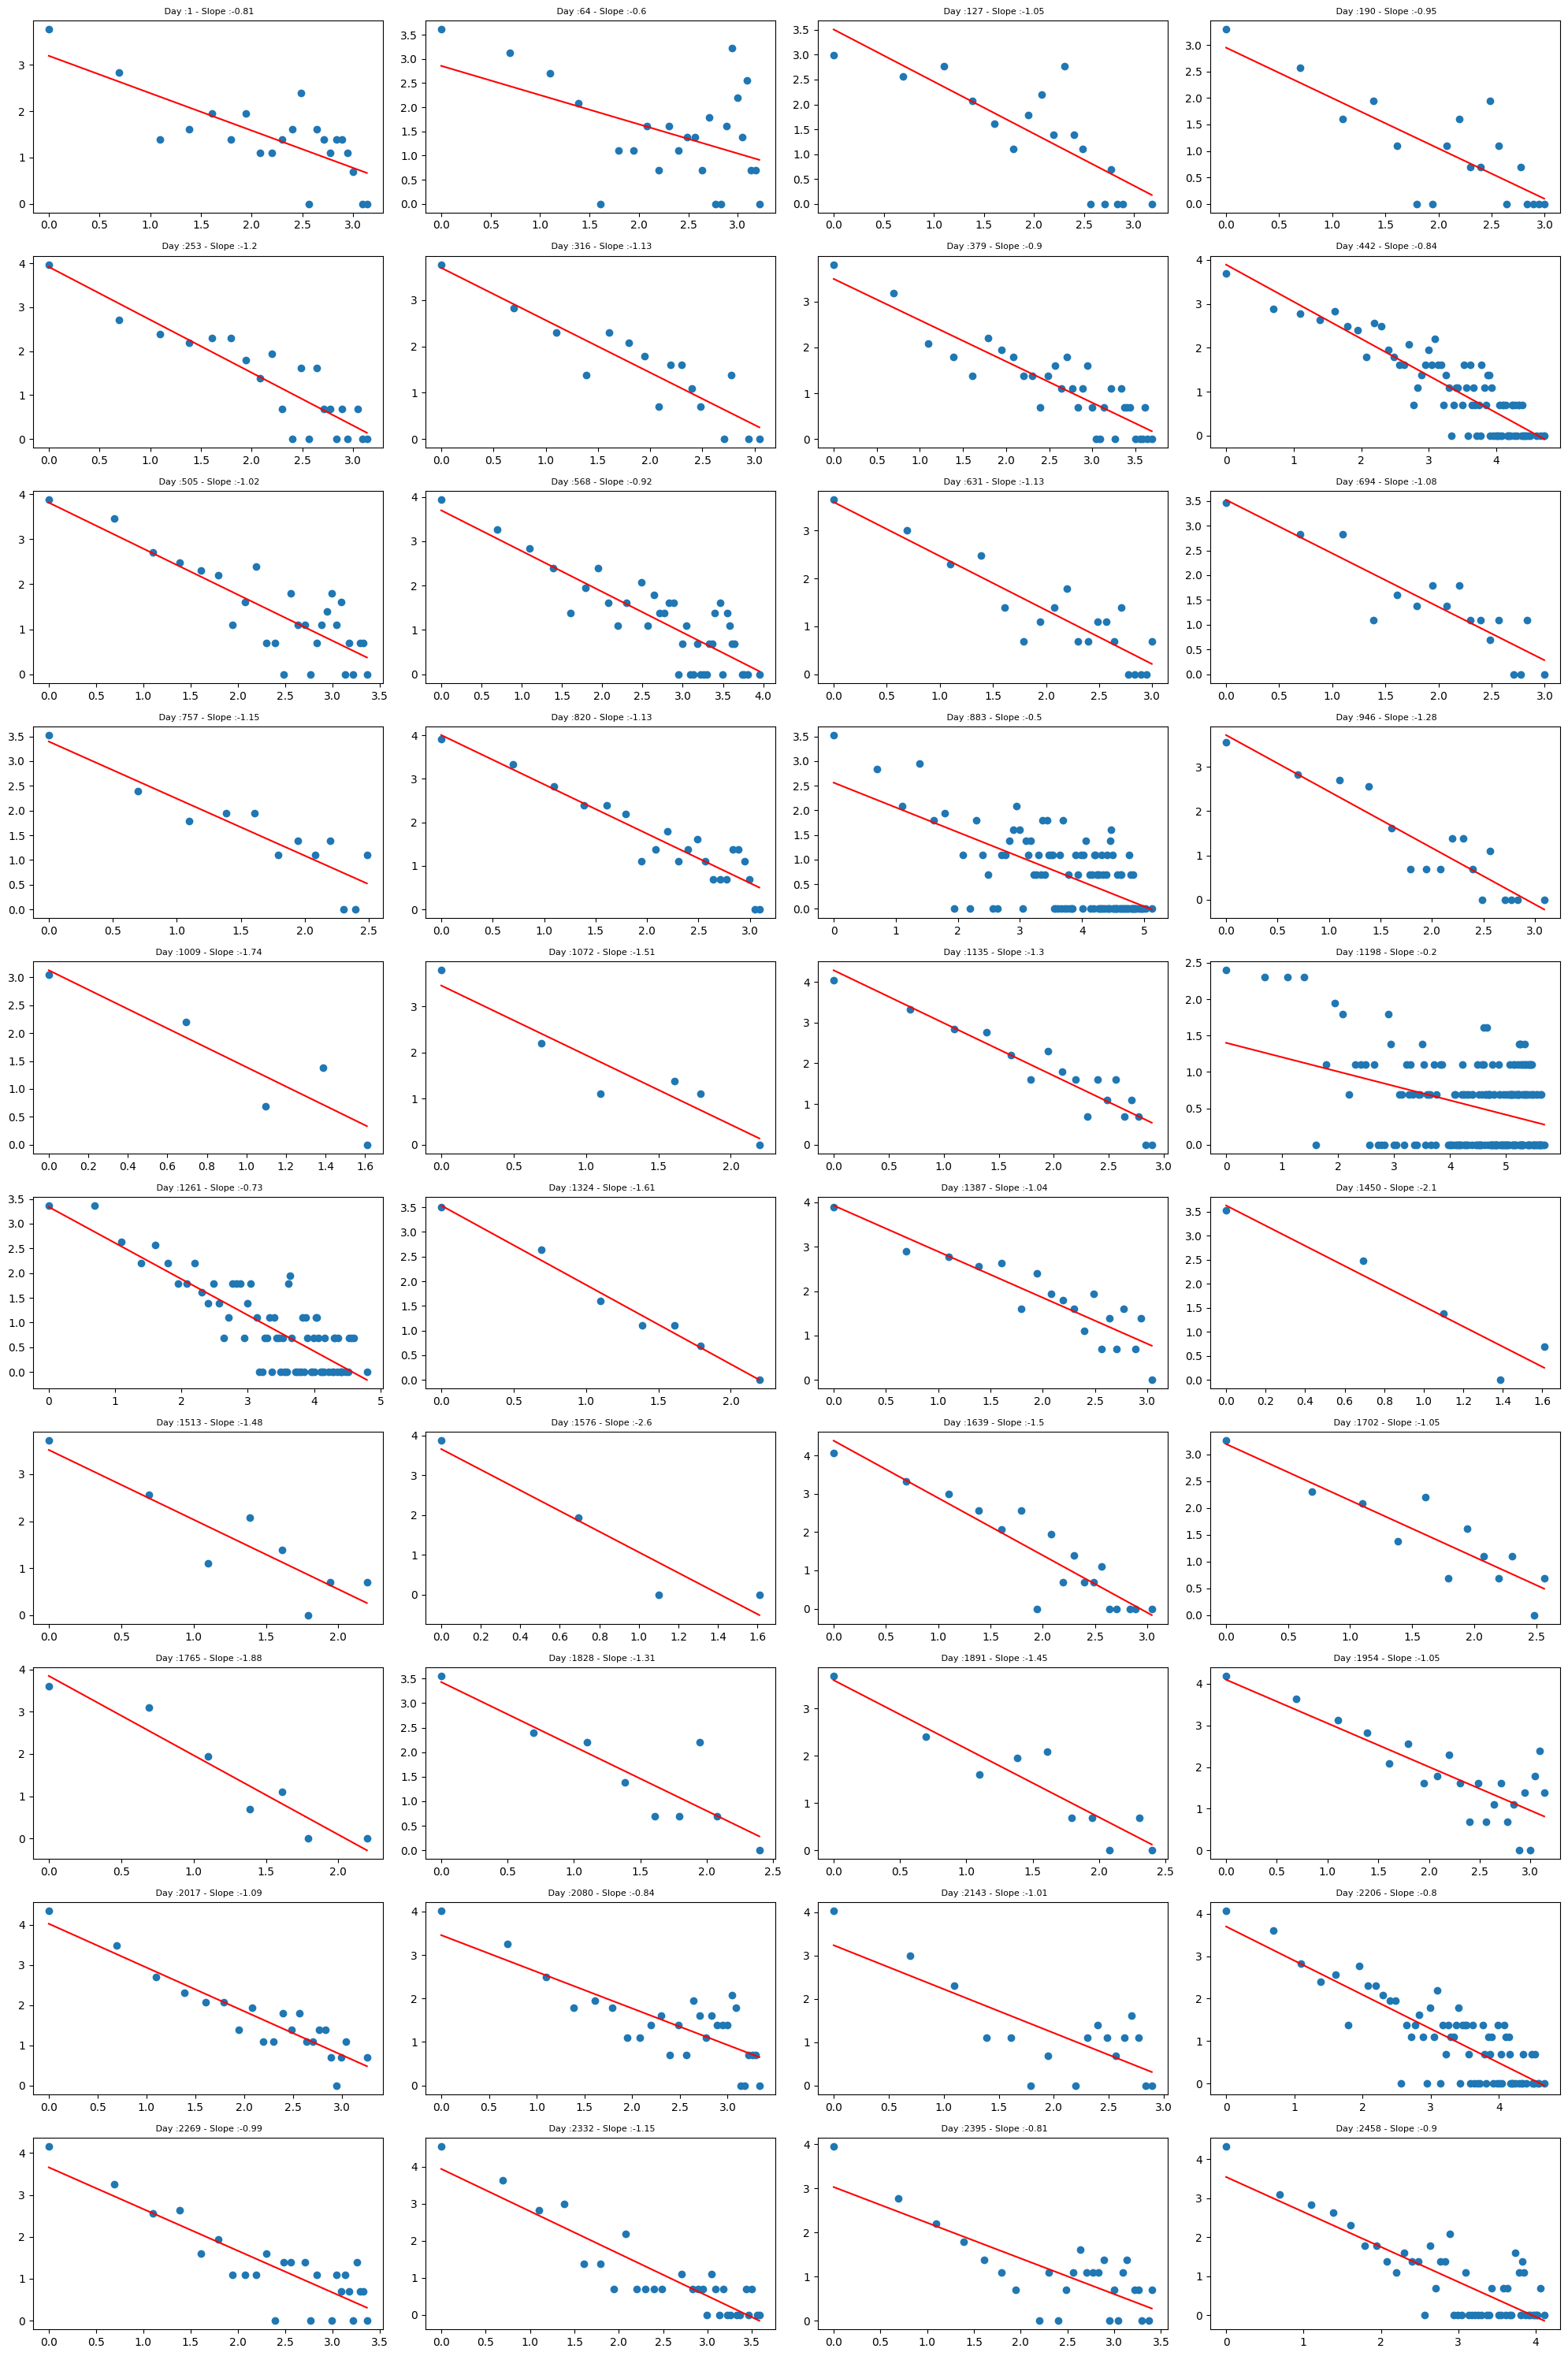

In [ ]:
# 5 Result 
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in G_dict[Y].nodes():
            deg = G_dict[Y].degree(n)
            if deg not in degs.keys():
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k, v) in items]
        y= [v for (k, v) in items]
        xlog= np.array([np.log(k) for (k, v) in items])
        ylog= np.array([np.log(v) for (k, v) in items])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        col.set_title(f" Day :{Y} - Slope :{round(slope,2)}", fontsize=8)
        Y = Y + W
plt.tight_layout()
plt.show()

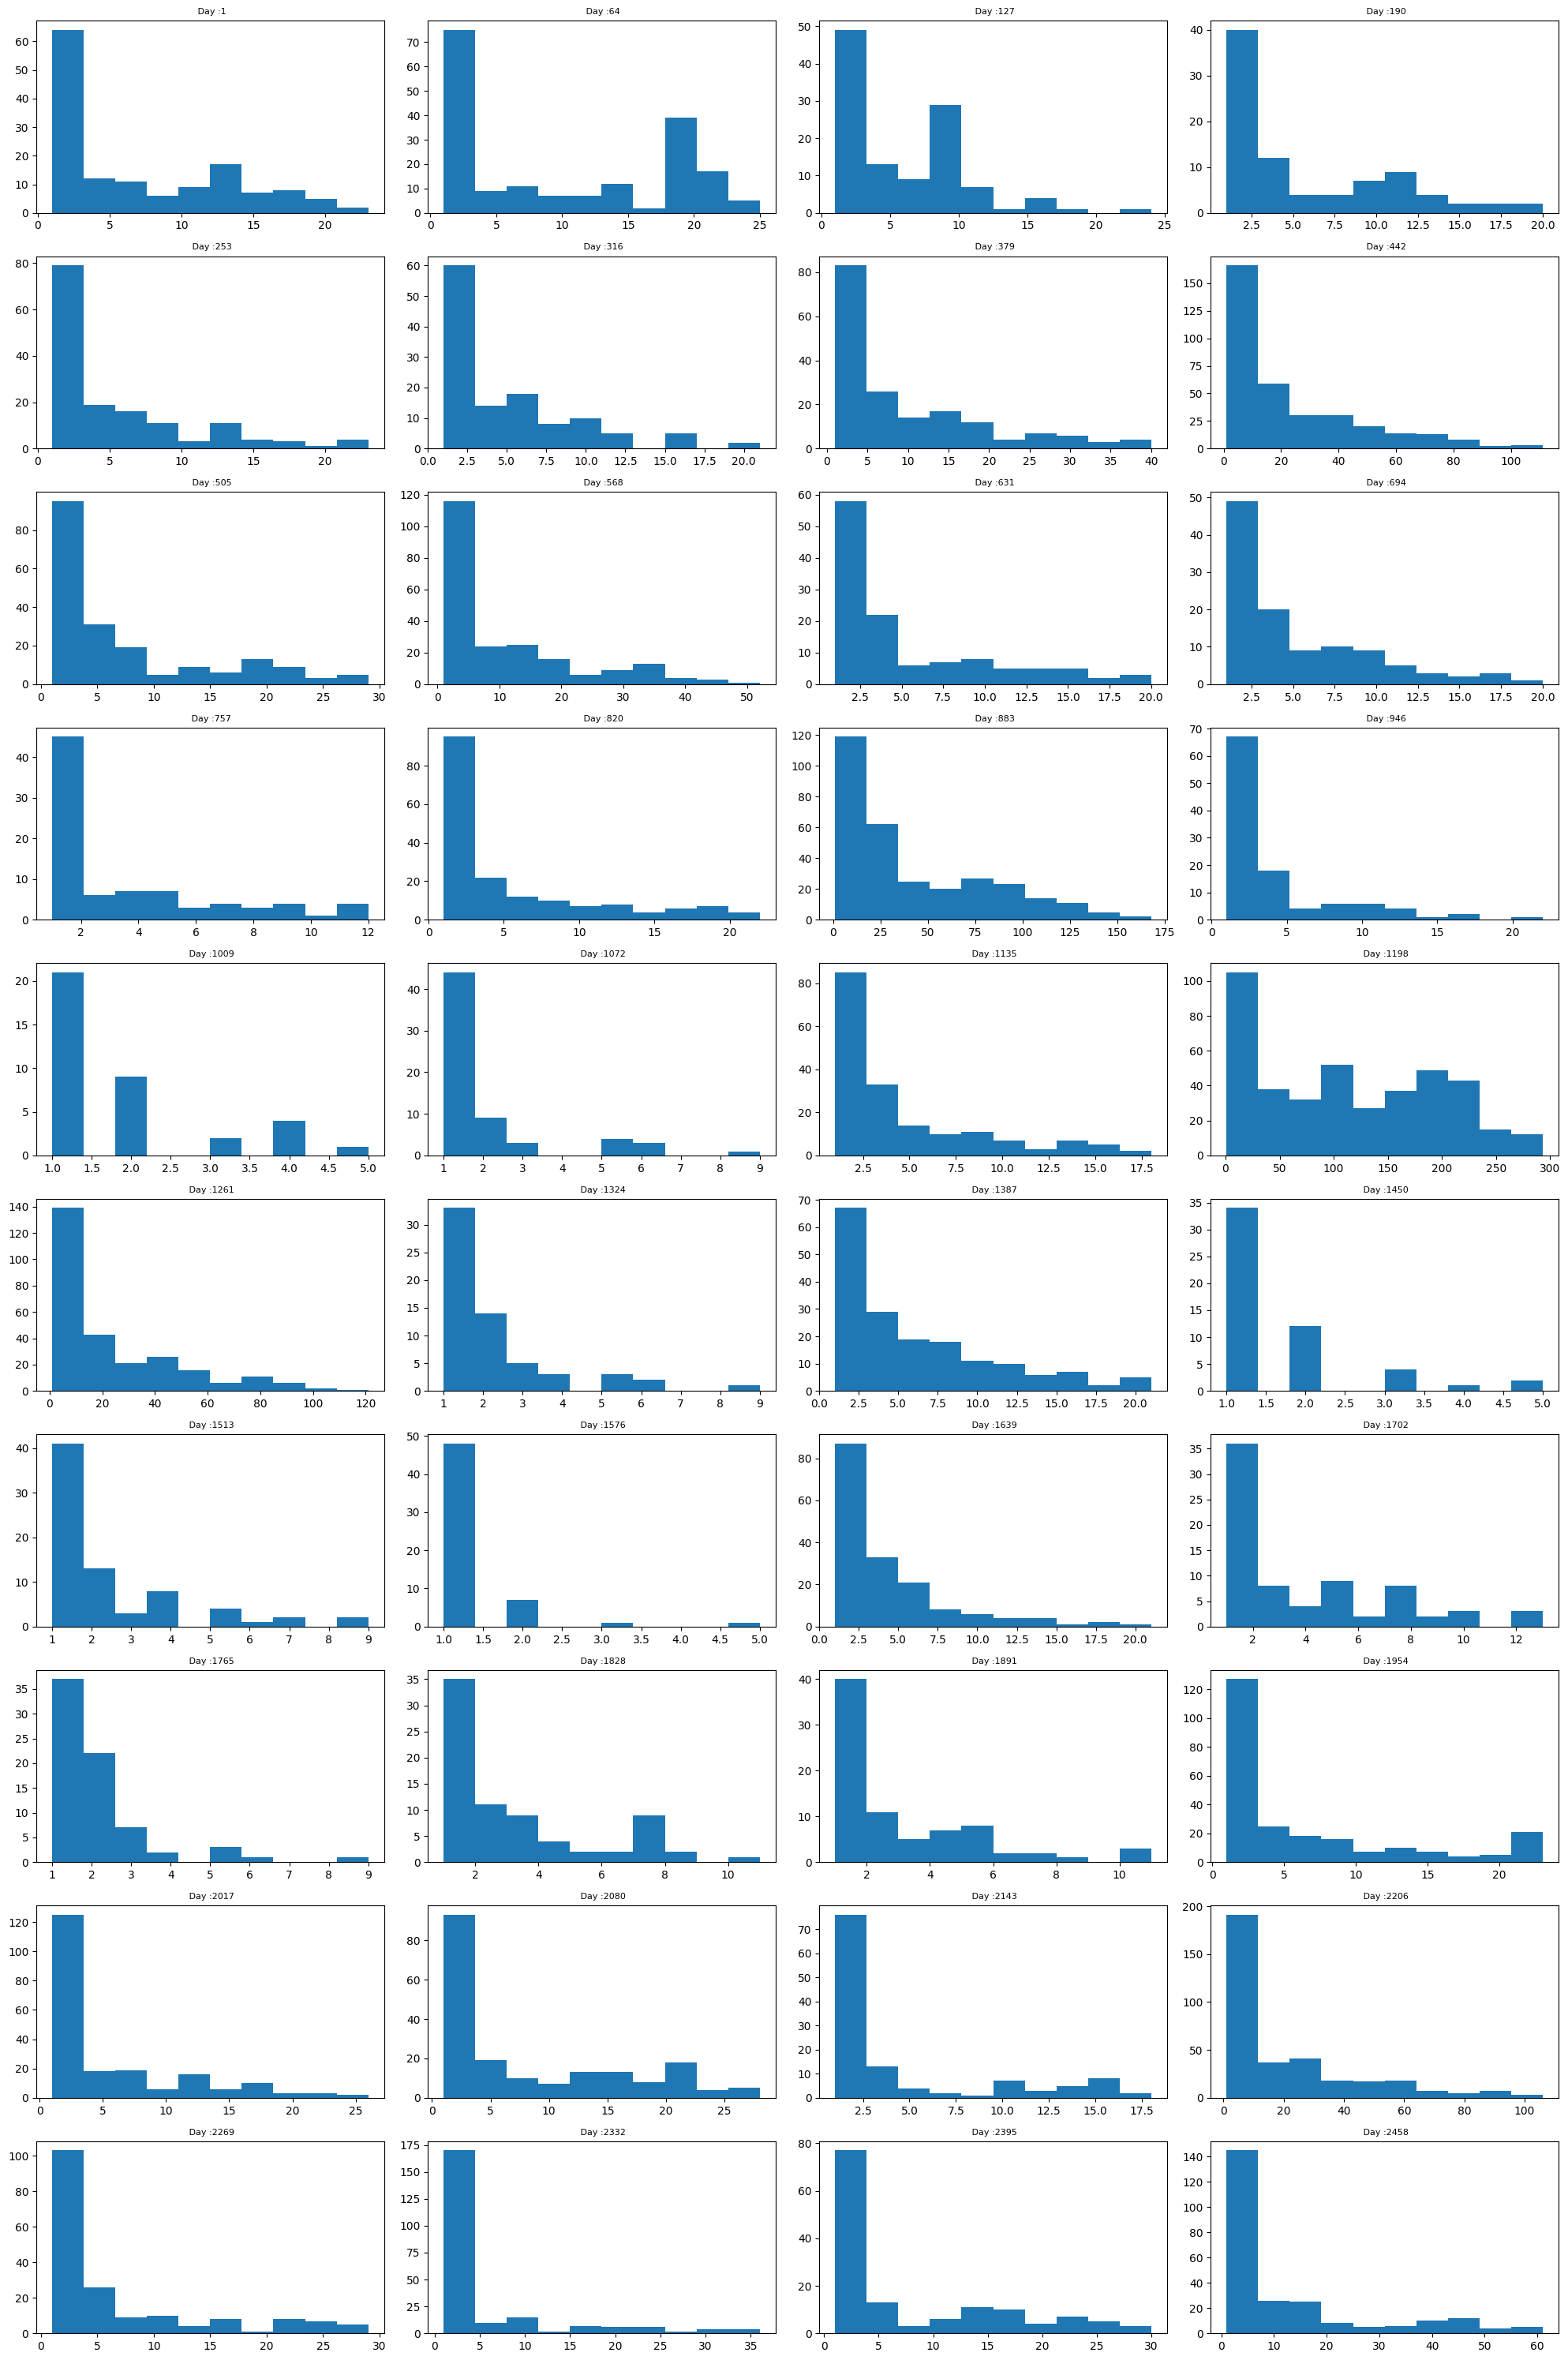

In [ ]:
## Explore graph properties
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
y = 1
for row in ax:
    for col in row:
        deg_dist = [v for k,v in G_dict[y].degree()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title(f" Day :{y}", fontsize=8)
        y = y + W
plt.tight_layout()
plt.show()

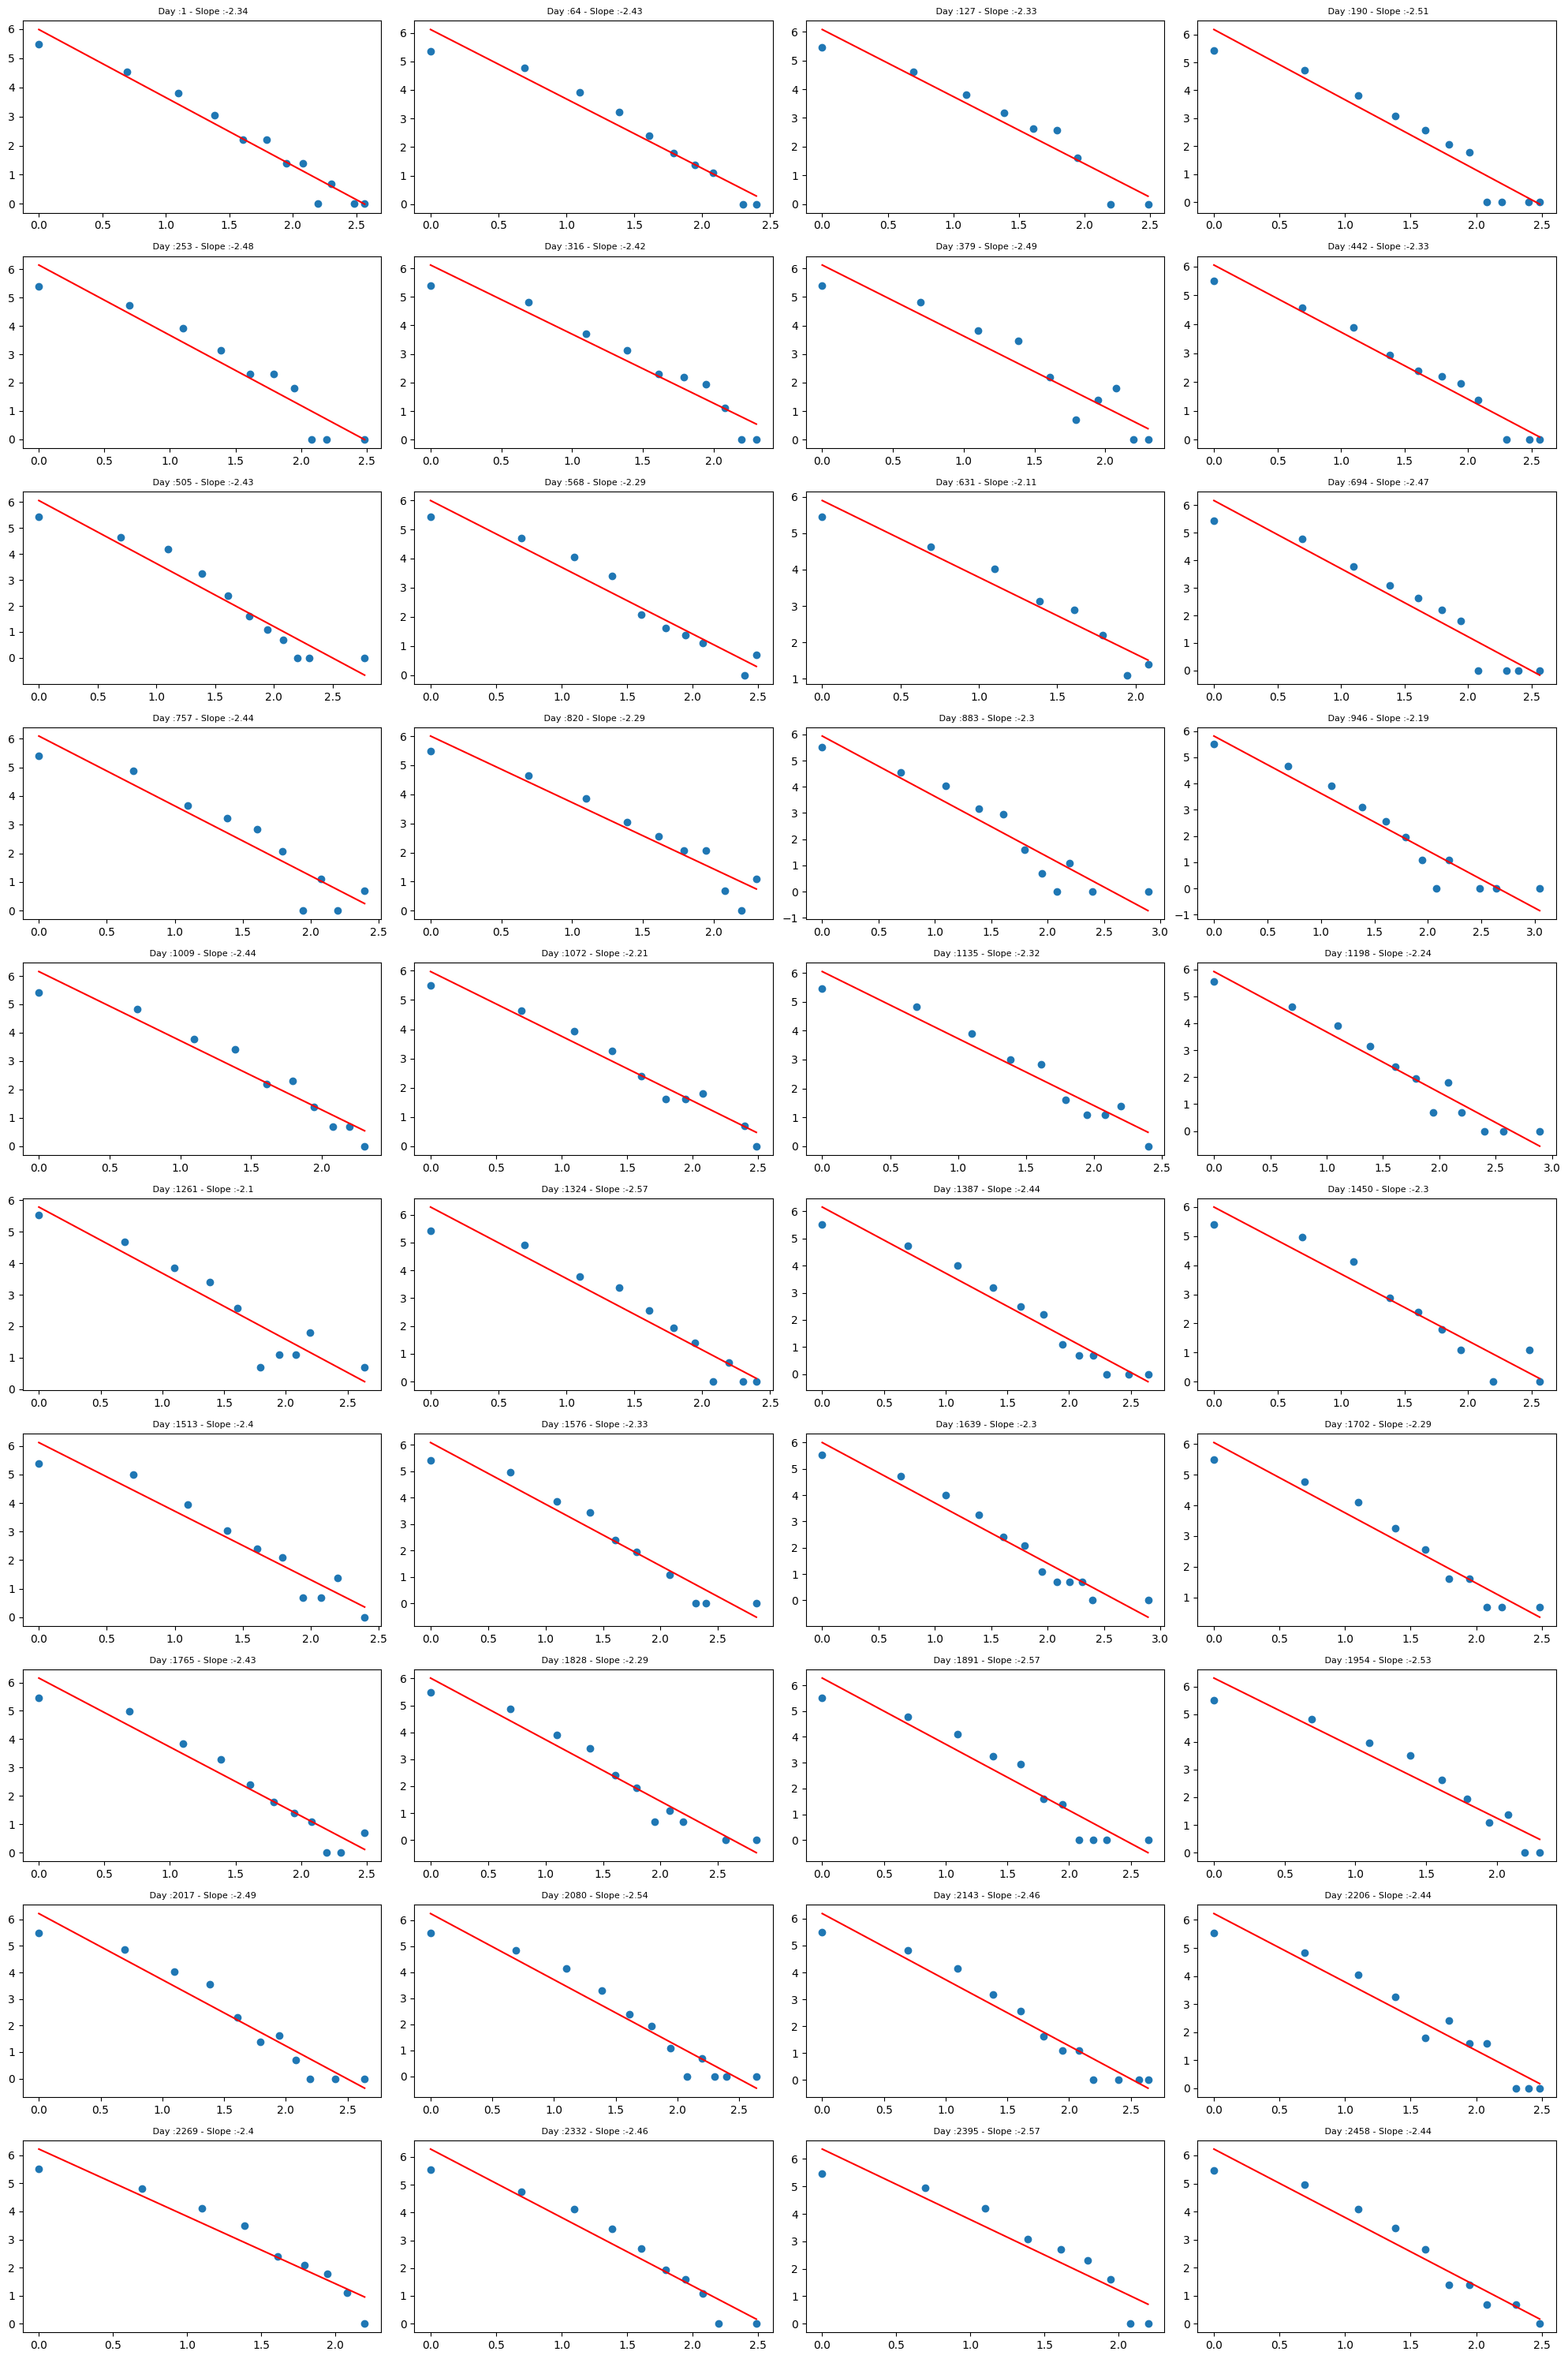

In [ ]:
## Explore graph properties cell 23
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in GMST_dict[Y].nodes():
            deg = GMST_dict[Y].degree(n)
            if deg not in degs.keys():
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k, v) in items]
        y= [v for (k, v) in items]
        xlog= np.array([np.log(k) for (k, v) in items])
        ylog= np.array([np.log(v) for (k, v) in items])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        col.set_title(f" Day :{Y} - Slope :{round(slope,2)}", fontsize=8)
        Y = Y + W
plt.tight_layout()
plt.show()

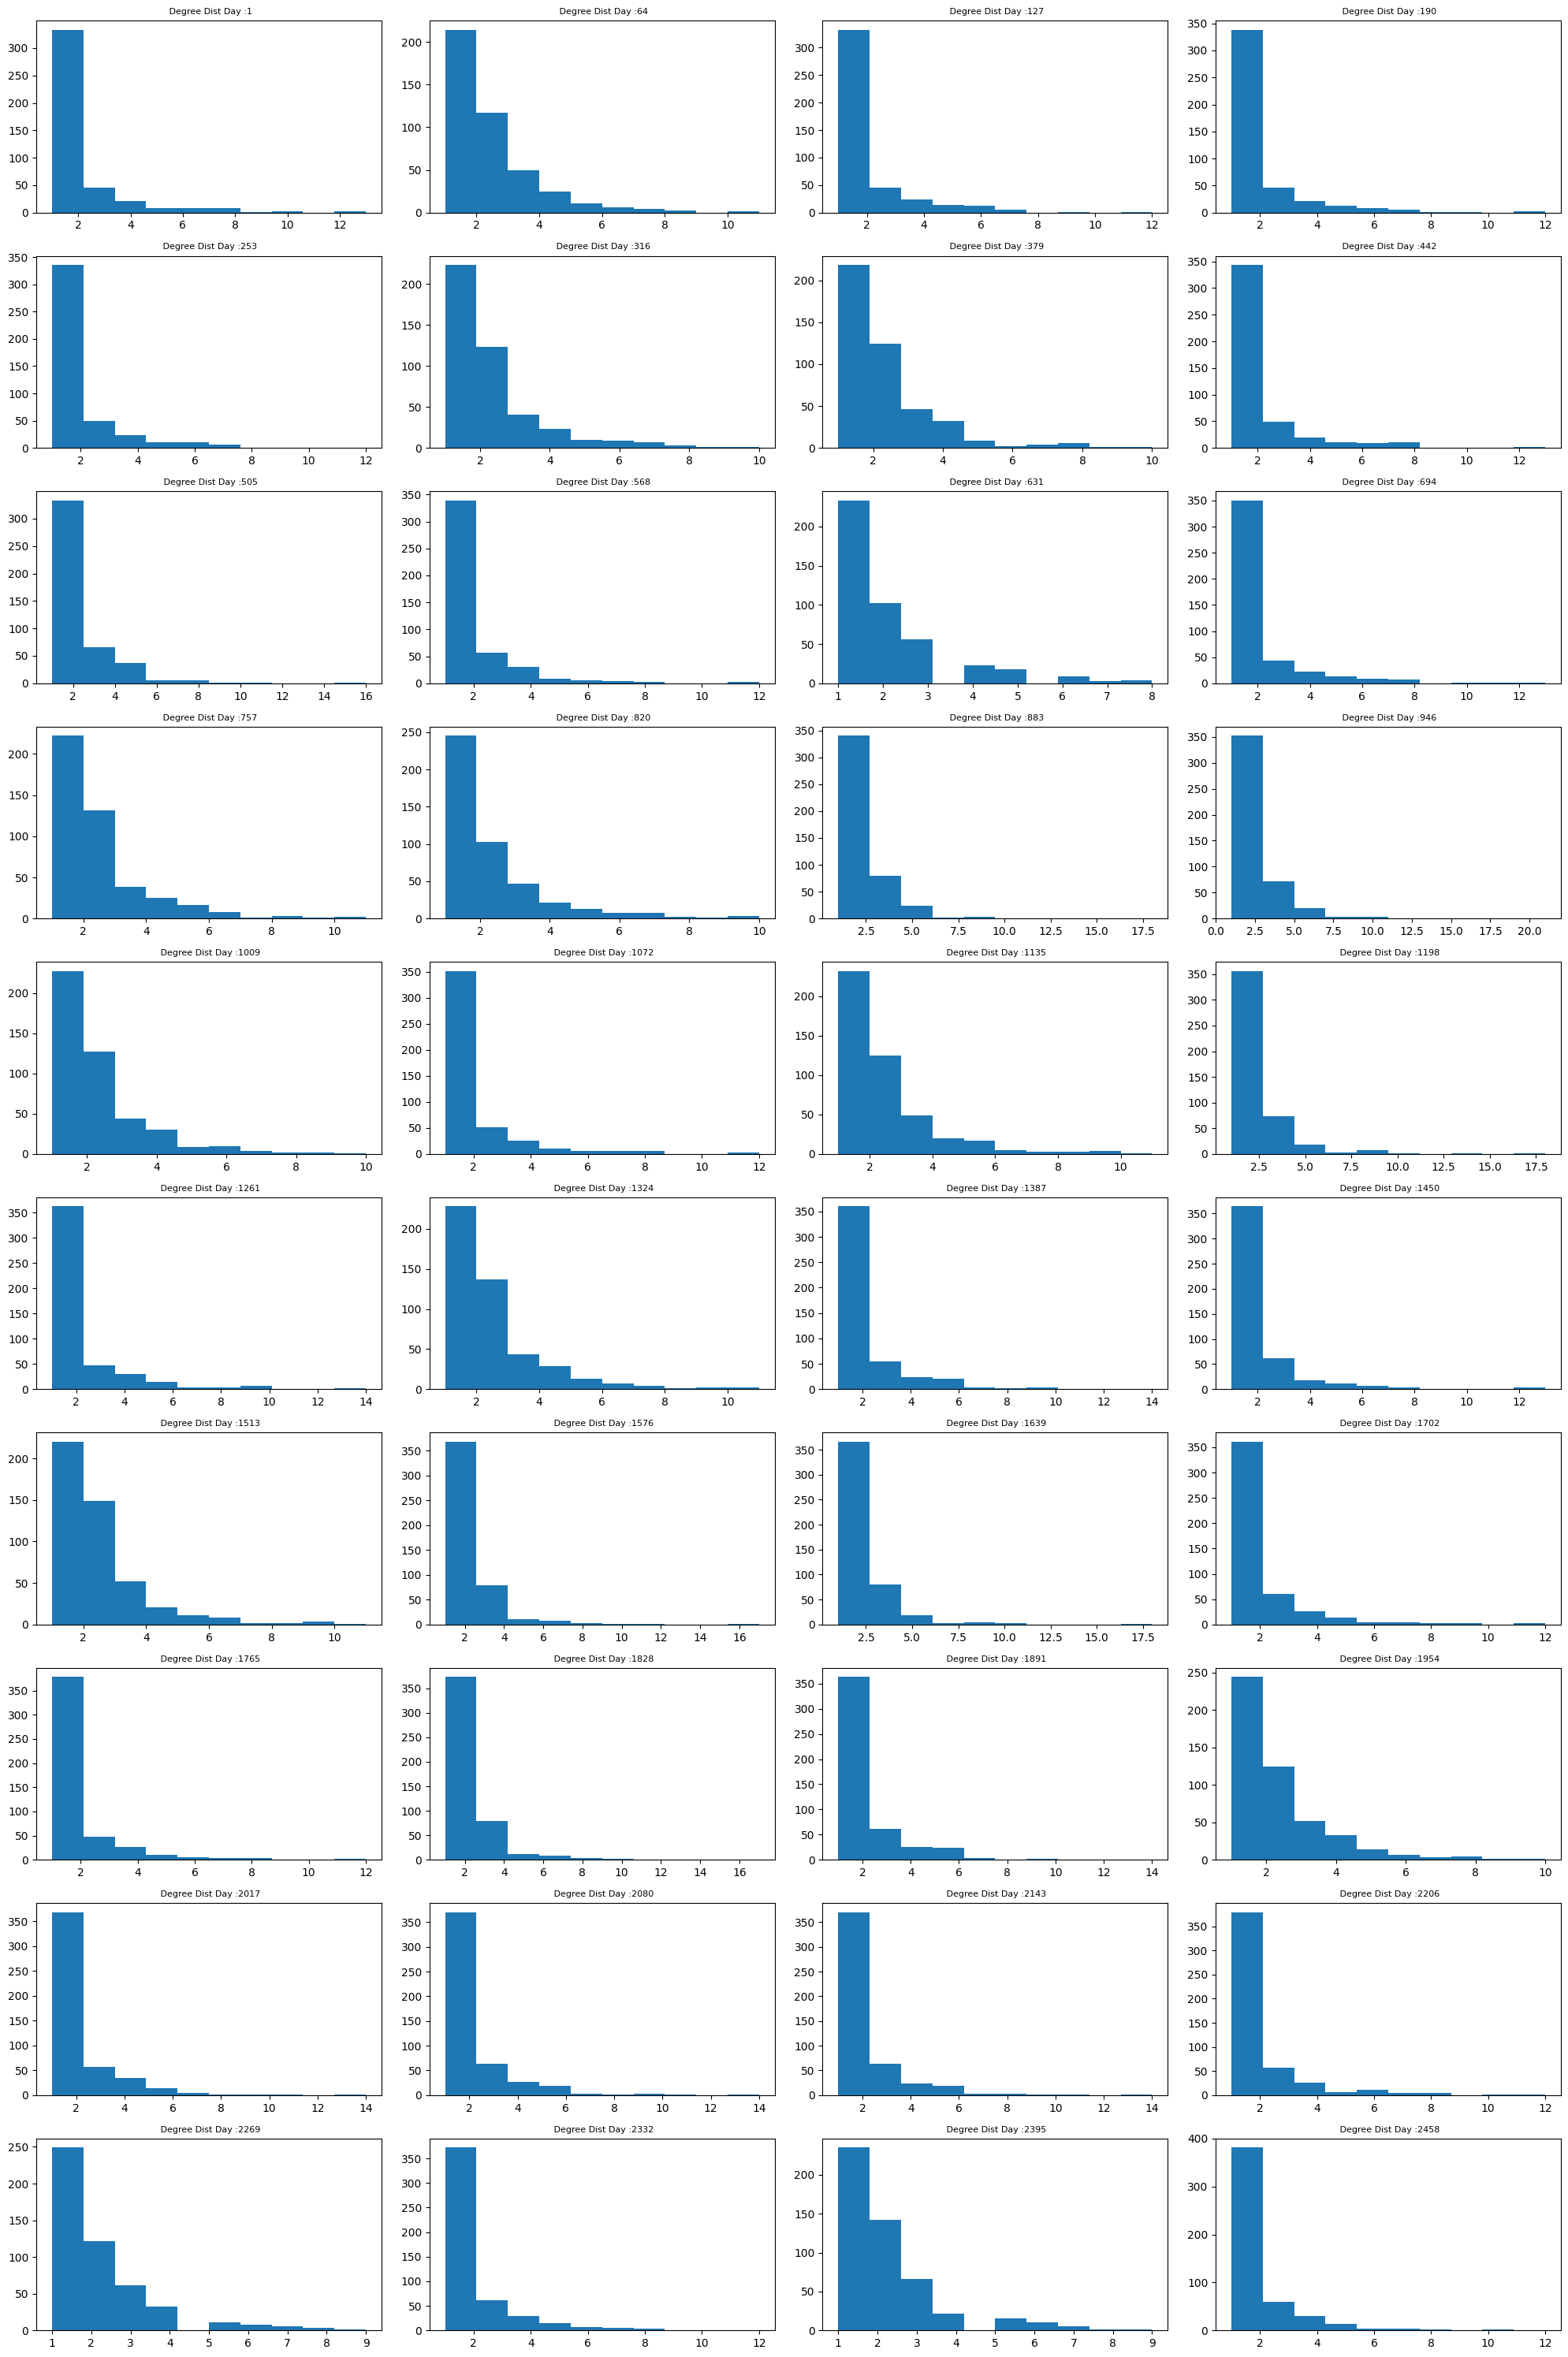

In [ ]:
## Explore graph properties cell 24
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
y = 1
for row in ax:
    for col in row:
        deg_dist = [v for k,v in GMST_dict[y].degree()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title(f" Degree Dist Day :{y}", fontsize=8)
        y = y + W
plt.tight_layout()
plt.show()

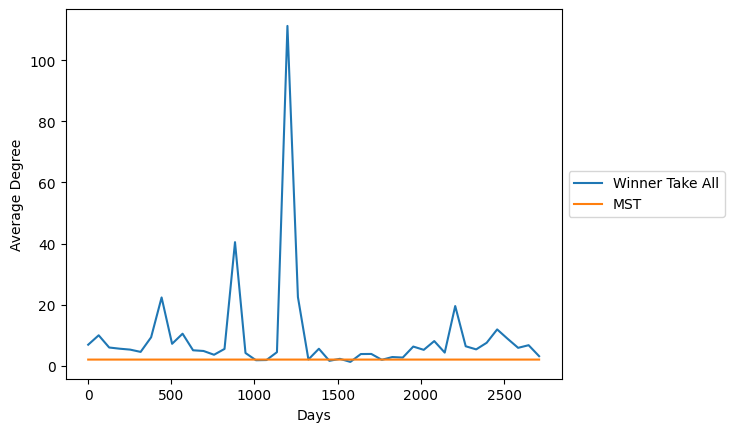

In [ ]:
# 5.2 cell 25
import matplotlib.pyplot as plt
%matplotlib inline
avgdf=attrib_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
avgdf=attribMST_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
plt.xlabel('Days')
plt.ylabel('Average Degree')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.show()

In [ ]:
# 5.3 WTA cell 26
attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                               Name Degree  \
6949  2710    RIG                         Transocean   14.0   
6951  2710    DVN                 Devon Energy Corp.   14.0   
6954  2710    MRO                 Marathon Oil Corp.   12.0   
6840  2647    PRU               Prudential Financial   26.0   
6842  2647    UNM                         Unum Group   26.0   
6839  2647    PNC             PNC Financial Services   25.0   
6698  2584    AEE                        Ameren Corp   18.0   
6706  2584     ES                  Eversource Energy   18.0   
6708  2584    LNT                Alliant Energy Corp   18.0   
6490  2521     MS                     Morgan Stanley   41.0   
6488  2521    DFS        Discover Financial Services   39.0   
6422  2521      O          Realty Income Corporation   37.0   
6182  2458    AMP               Ameriprise Financial   61.0   
6171  2458    ETN                  Eaton Corporation   58.0   
6230  2458    MCO                       Moody's Corp   58.0   
6026  2395      C                     Citigroup Inc.   30.0   
6035  2395    PRU               Prudential Financial   30.0   
6031  2395     MS                     Morgan Stanley   29.0   
5831  2332     MS                     Morgan Stanley   36.0   
5838  2332    PNC             PNC Financial Services   35.0   
5828  2332     BK  The Bank of New York Mellon Corp.   33.0   
5627  2269    BBT                   BB&T Corporation   29.0   
5637  2269    PNC             PNC Financial Services   28.0   
5638  2269    PRU               Prudential Financial   28.0   
5266  2206    HON               Honeywell Int'l Inc.  106.0   
5293  2206    WFC                        Wells Fargo   98.0   
5256  2206  BRK.B                 Berkshire Hathaway   97.0   
5150  2143    BXP                  Boston Properties   18.0   
5156  2143    REG        Regency Centers Corporation   17.0   
5153  2143    FRT    Federal Realty Investment Trust   16.0   
5008  2080    AMP               Ameriprise Financial   28.0   
5027  2080    STI                     SunTrust Banks   27.0   
5028  2080    WFC                        Wells Fargo   27.0   
4756  2017    AMP               Ameriprise Financial   26.0   
4770  2017    MET                       MetLife Inc.   26.0   
4795  2017    USB                       U.S. Bancorp   21.0   
4501  1954    AEE                        Ameren Corp   23.0   
4506  1954      D                 Dominion Resources   23.0   
4513  1954    LNT                Alliant Energy Corp   23.0   
4410  1891    CMS                         CMS Energy   11.0   
4413  1891    SCG                         SCANA Corp   10.0   
4415  1891    XEL                    Xcel Energy Inc   10.0   
4350  1828    AMP               Ameriprise Financial   11.0   
4357  1828    PRU               Prudential Financial    8.0   
4361  1828    UNM                         Unum Group    8.0   
4268  1765    WFC                        Wells Fargo    9.0   
4266  1765      L                        Loews Corp.    6.0   
4261  1765    SCG                         SCANA Corp    5.0   
4187  1702    PEG       Public Serv. Enterprise Inc.   13.0   
4190  1702    WEC               Wec Energy Group Inc   13.0   
4199  1702    UDR                            UDR Inc   12.0   
4047  1639    PFG          Principal Financial Group   21.0   
4026  1639    WEC               Wec Energy Group Inc   18.0   
4023  1639    LNT                Alliant Energy Corp   17.0   
3972  1576    LNC                   Lincoln National    5.0   
4004  1576    PRU               Prudential Financial    3.0   
3966  1576    AME                         AMETEK Inc    2.0   
3894  1513    SCG                         SCANA Corp    9.0   
3896  1513    XEL                    Xcel Energy Inc    9.0   
3889  1513    AEP            American Electric Power    7.0   
3843  1450    OXY               Occidental Petroleum    5.0   
3857  1450    XEL                    Xcel Energy Inc    5.0   
3836  1450    IVZ                   

In [ ]:
# MST cell 27
attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                                    Name Degree  \
20276  2710    HON                    Honeywell Int'l Inc.    9.0   
20270  2710    HCP                                HCP Inc.    7.0   
20441  2710    RIG                              Transocean    7.0   
19655  2647    CMS                              CMS Energy   11.0   
19945  2647    ROK                Rockwell Automation Inc.    9.0   
19597  2647    APH                           Amphenol Corp    8.0   
19195  2584    DOV                             Dover Corp.    9.0   
19368  2584    MRO                      Marathon Oil Corp.    9.0   
19411  2584    PEP                            PepsiCo Inc.    9.0   
18626  2521  BRK.B                      Berkshire Hathaway    8.0   
18651  2521     CL                       Colgate-Palmolive    8.0   
18685  2521    DFS             Discover Financial Services    8.0   
18224  2458    ETN                       Eaton Corporation   12.0   
18159  2458    CMI                            Cummins Inc.   10.0   
18356  2458    MCO                            Moody's Corp   10.0   
17594  2395    AMG           Affiliated Managers Group Inc    9.0   
17809  2395    ITW                     Illinois Tool Works    8.0   
17663  2395    CMS                              CMS Energy    7.0   
17069  2332      A                Agilent Technologies Inc   12.0   
17380  2332     MS                          Morgan Stanley    9.0   
17100  2332   AMGN                               Amgen Inc    8.0   
16682  2269    COP                          ConocoPhillips    9.0   
16796  2269    HON                    Honeywell Int'l Inc.    8.0   
16833  2269    KMB                          Kimberly-Clark    8.0   
16303  2206    HON                    Honeywell Int'l Inc.   12.0   
16375  2206    MCO                            Moody's Corp   11.0   
16332  2206    JPM                    JPMorgan Chase & Co.   10.0   
15607  2143    ADP               Automatic Data Processing   14.0   
16044  2143    UTX                     United Technologies   13.0   
15894  2143    MMC                        Marsh & McLennan   11.0   
15142  2080    AMP                    Ameriprise Financial   14.0   
15353  2080    ITW                     Illinois Tool Works   11.0   
15409  2080    MMM                              3M Company   10.0   
14658  2017    AMP                    Ameriprise Financial   14.0   
14803  2017    FIS  Fidelity National Information Services   11.0   
14868  2017    ITW                     Illinois Tool Works    9.0   
14440  1954    MMM                              3M Company   10.0   
14175  1954    AMP                    Ameriprise Financial    9.0   
14207  1954    BLK                               BlackRock    8.0   
13879  1891    HON                    Honeywell Int'l Inc.   14.0   
14014  1891     PH                         Parker-Hannifin   10.0   
14082  1891    TMK                         Torchmark Corp.    9.0   
13600  1828    TMK                         Torchmark Corp.   17.0   
13210  1828    AME                              AMETEK Inc   13.0   
13310  1828    DIS                 The Walt Disney Company    9.0   
13049  1765    PFG               Principal Financial Group   12.0   
13159  1765    WFC                             Wells Fargo   12.0   
12733  1765    AMP                    Ameriprise Financial   10.0   
12255  1702    AMP                    Ameriprise Financial   12.0   
12440  1702    HON                    Honeywell Int'l Inc.   12.0   
12591  1702      R                            Ryder System    9.0   
12093  1639    PFG               Principal Financial Group   18.0   
12202  1639    WEC                    Wec Energy Group Inc   11.0   
11786  1639    APC                 Anadarko Petroleum Corp   10.0   
11308  1576    AMP                    Ameriprise Financial   17.0   
11691  1576   TROW                     T. Rowe Price Group   11.0   
11542  1576    LNC                        Lincoln National   10.0   
1127

In [ ]:
# Cell 28
df1=attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df2=attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df3=pd.concat([df1, df2], axis=1).fillna(0)
df3.columns = ['t1','t2']

[]

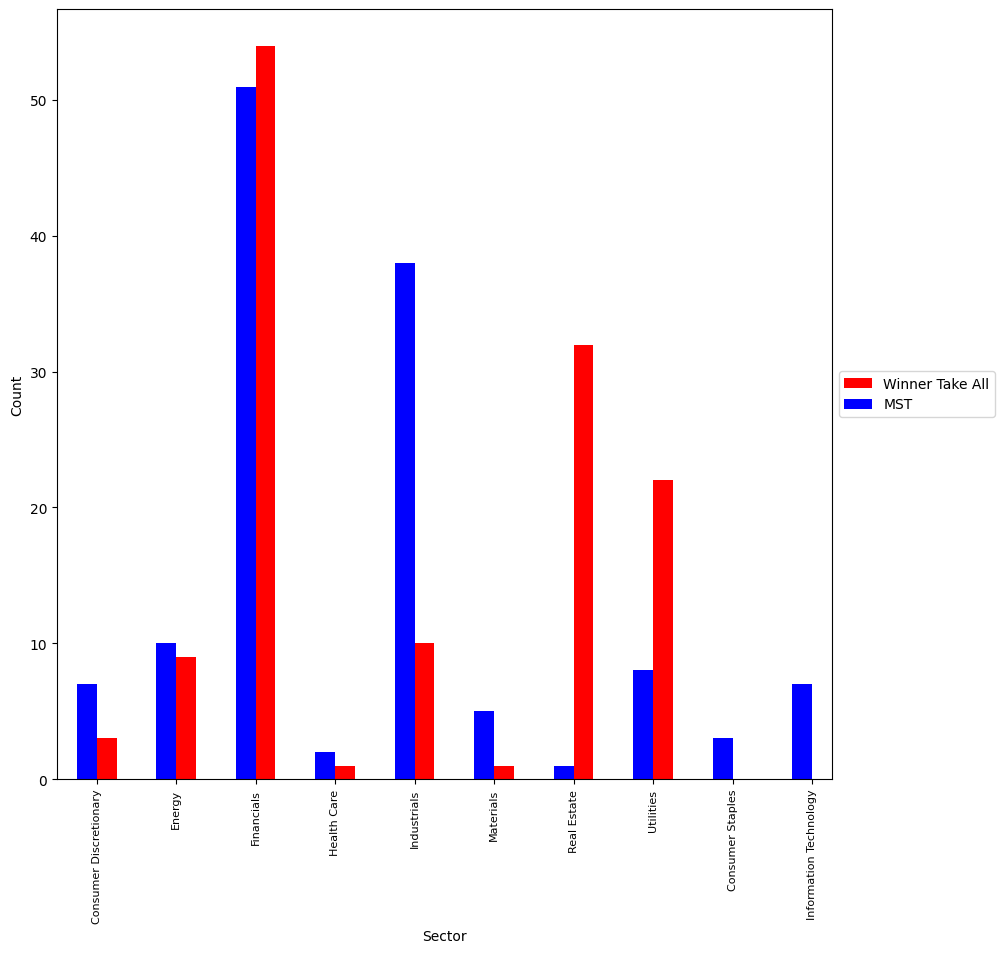

In [ ]:
# Cell 29
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
df3['t1'].plot(kind='bar',color='red', position=0, width=0.25)
df3['t2'].plot(kind='bar',color='blue', position=1, width=0.25)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.plot()

In [ ]:
# 5.4 WTA Cell 30
attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                              Name Betweeness  \
6939  2710   FOXA  Twenty-First Century Fox Class A   0.006581   
6999  2710    LKQ                   LKQ Corporation   0.005412   
6947  2710    COP                    ConocoPhillips   0.003708   
6842  2647    UNM                        Unum Group   0.011563   
6840  2647    PRU              Prudential Financial   0.007078   
6852  2647   SCHW        Charles Schwab Corporation   0.005239   
6742  2584    LNC                  Lincoln National   0.007059   
6748  2584     GS               Goldman Sachs Group   0.006757   
6747  2584   ZION                     Zions Bancorp   0.005617   
6382  2521    MMC                  Marsh & McLennan   0.261591   
6466  2521    BDX                  Becton Dickinson   0.247085   
6381  2521      A          Agilent Technologies Inc   0.241643   
6246  2458    DOV                       Dover Corp.   0.098218   
6302  2458    NOV       National Oilwell Varco Inc.   0.051387   
6171  2458    ETN                 Eaton Corporation   0.048963   
6035  2395    PRU              Prudential Financial   0.016431   
6046  2395    AMP              Ameriprise Financial   0.008639   
6026  2395      C                    Citigroup Inc.   0.005327   
5881  2332    DHR                     Danaher Corp.   0.114214   
5922  2332    XYL                        Xylem Inc.   0.111111   
5887  2332     PH                   Parker-Hannifin   0.100377   
5629  2269      C                    Citigroup Inc.   0.015367   
5678  2269    COF             Capital One Financial   0.013035   
5690  2269   MSFT                   Microsoft Corp.   0.010677   
5266  2206    HON              Honeywell Int'l Inc.   0.180326   
5312  2206    KMB                    Kimberly-Clark   0.098523   
5521  2206    XOM                 Exxon Mobil Corp.     0.0965   
5133  2143    UTX               United Technologies   0.002801   
5172  2143    NOC            Northrop Grumman Corp.   0.002801   
5140  2143    LNT               Alliant Energy Corp    0.00259   
5017  2080    ITW               Illinois Tool Works   0.024448   
4935  2080    BEN                Franklin Resources   0.021803   
5006  2080     PH                   Parker-Hannifin   0.017168   
4769  2017    BEN                Franklin Resources   0.042173   
4773  2017    EMR          Emerson Electric Company   0.042114   
4878  2017    ROP                  Roper Industries   0.034119   
4499  1954    MMM                        3M Company   0.056505   
4559  1954    MET                      MetLife Inc.   0.045549   
4538  1954    PFG         Principal Financial Group   0.028702   
4445  1891    HON              Honeywell Int'l Inc.   0.070374   
4424  1891    TMK                   Torchmark Corp.   0.048119   
4437  1891    PNC            PNC Financial Services   0.044289   
4359  1828    TMK                   Torchmark Corp.   0.088856   
4347  1828    MMC                  Marsh & McLennan   0.086326   
4350  1828    AMP              Ameriprise Financial   0.081451   
4268  1765    WFC                       Wells Fargo   0.037167   
4266  1765      L                       Loews Corp.   0.023865   
4277  1765   CINF              Cincinnati Financial   0.018779   
4187  1702    PEG      Public Serv. Enterprise Inc.   0.013239   
4191  1702    AIV       Apartment Investment & Mgmt   0.011686   
4190  1702    WEC              Wec Energy Group Inc   0.011629   
4047  1639    PFG         Principal Financial Group   0.112381   
4039  1639    ROK          Rockwell Automation Inc.   0.060733   
4059  1639    MRO                Marathon Oil Corp.    0.04277   
3972  1576    LNC                  Lincoln National   0.010065   
3970  1576    AMP              Ameriprise Financial   0.006494   
3969  1576    AMG     Affiliated Managers Group Inc   0.003896   
3909  1513     GS               Goldman Sachs Group   0.044901   
3943  1513    LNC                  Lincoln National   0.041667   
3941  1513    USB                      U.S. B

In [ ]:
# MST Cell 31
attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                           Name Betweeness  \
20301  2710    IVZ                   Invesco Ltd.   0.608116   
20113  2710    BEN             Franklin Resources   0.562561   
20276  2710    HON           Honeywell Int'l Inc.   0.555908   
19608  2647    BAC           Bank of America Corp   0.565968   
20006  2647    UNM                     Unum Group   0.559007   
19968  2647    STI                 SunTrust Banks   0.557166   
19334  2584    LNC               Lincoln National   0.622926   
19343  2584     MA                Mastercard Inc.   0.598135   
19513  2584    USB                   U.S. Bancorp   0.535171   
18626  2521  BRK.B             Berkshire Hathaway   0.618647   
18861  2521    MMC               Marsh & McLennan   0.543243   
18617  2521    BDX               Becton Dickinson   0.524445   
18093  2458    AMP           Ameriprise Financial   0.656739   
18356  2458    MCO                   Moody's Corp    0.62827   
18224  2458    ETN              Eaton Corporation   0.461892   
17806  2395     IR             Ingersoll-Rand PLC   0.627493   
17810  2395    IVZ                   Invesco Ltd.   0.604643   
17594  2395    AMG  Affiliated Managers Group Inc   0.553234   
17121  2332    BAC           Bank of America Corp    0.63635   
17380  2332     MS                 Morgan Stanley   0.606261   
17320  2332    JPM           JPMorgan Chase & Co.   0.566071   
17045  2269    WFC                    Wells Fargo     0.6792   
16666  2269   CINF           Cincinnati Financial   0.544617   
16642  2269  BRK.B             Berkshire Hathaway    0.48872   
16332  2206    JPM           JPMorgan Chase & Co.   0.684052   
16450  2206    PRU           Prudential Financial   0.597323   
16491  2206    STI                 SunTrust Banks   0.508724   
15607  2143    ADP      Automatic Data Processing   0.642566   
15894  2143    MMC               Marsh & McLennan   0.628602   
16044  2143    UTX            United Technologies   0.569319   
15142  2080    AMP           Ameriprise Financial   0.774324   
15353  2080    ITW            Illinois Tool Works   0.547503   
15354  2080    IVZ                   Invesco Ltd.    0.39412   
14658  2017    AMP           Ameriprise Financial     0.7231   
15010  2017    ROP               Roper Industries   0.544307   
15031  2017    STT             State Street Corp.   0.502513   
14207  1954    BLK                      BlackRock   0.651754   
14434  1954    MET                   MetLife Inc.   0.642696   
14507  1954    PRU           Prudential Financial   0.467275   
13879  1891    HON           Honeywell Int'l Inc.   0.651204   
14105  1891    UTX            United Technologies   0.613262   
13902  1891    ITW            Illinois Tool Works   0.496266   
13600  1828    TMK                Torchmark Corp.   0.719482   
13476  1828    MMC               Marsh & McLennan    0.53477   
13617  1828    UNM                     Unum Group   0.477817   
12733  1765    AMP           Ameriprise Financial    0.75568   
12961  1765      L                    Loews Corp.   0.498318   
13049  1765    PFG      Principal Financial Group   0.435557   
12255  1702    AMP           Ameriprise Financial   0.839343   
12591  1702      R                   Ryder System   0.406076   
12347  1702    DFS    Discover Financial Services   0.320586   
12093  1639    PFG      Principal Financial Group   0.804237   
11823  1639     CB                  Chubb Limited   0.462518   
11837  1639   CINF           Cincinnati Financial   0.448581   
11308  1576    AMP           Ameriprise Financial   0.805308   
11542  1576    LNC               Lincoln National    0.47234   
11691  1576   TROW            T. Rowe Price Group   0.352066   
11072  1513    LNC               Lincoln National   0.653664   
11270  1513    XOM              Exxon Mobil Corp.   0.585033   
11005  1513     GS            Goldman Sachs Group   0.494004   
10368  1450    AMP           Ameriprise Financial   0.752951   
10574  1450    IVZ                   I

In [ ]:
# Cell 32
# plotted the count of the sector of the high betweenness stocks in the windows and we can see that Finance stocks still lead however industrials come in number two.
df1=attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df2=attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df3=pd.concat([df1, df2], axis=1).fillna(0)
df3.columns = ['t1','t2']

[]

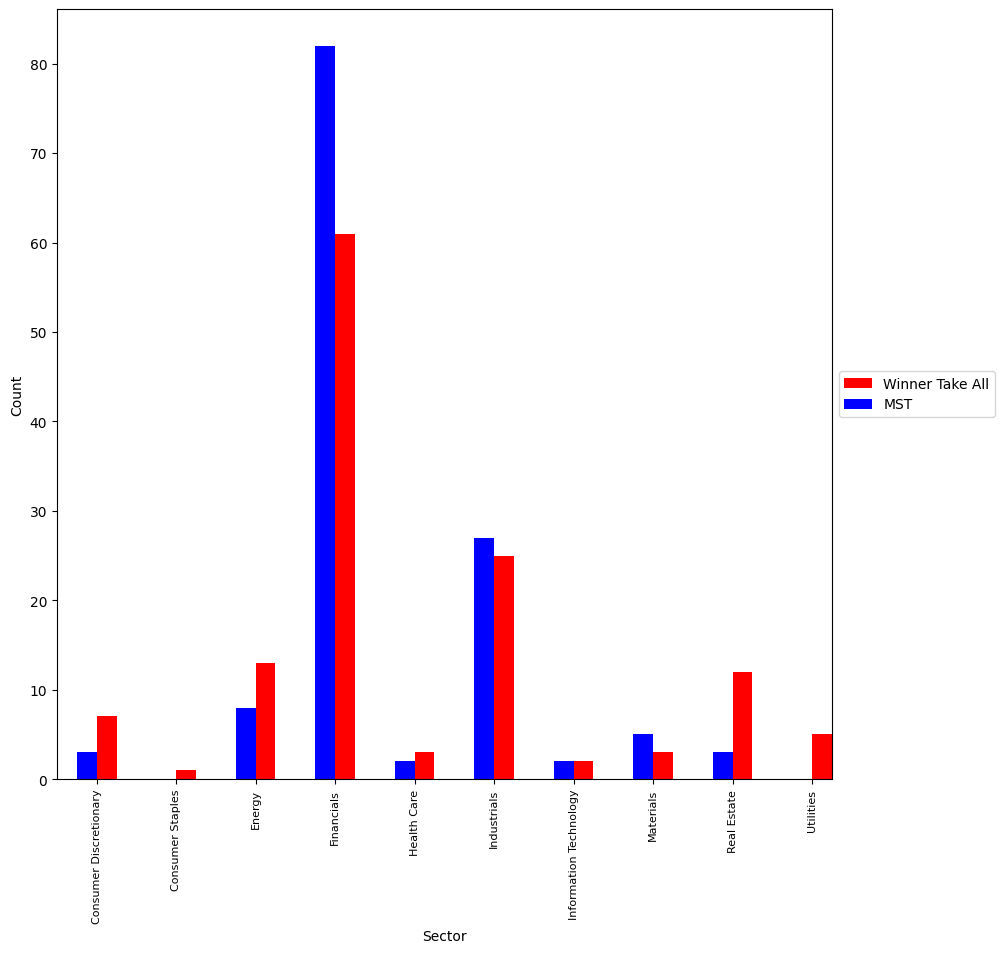

In [ ]:
# Cell 33
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
df3['t1'].plot(kind='bar',color='red', position=0, width=0.25)
df3['t2'].plot(kind='bar',color='blue', position=1, width=0.25)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.plot()

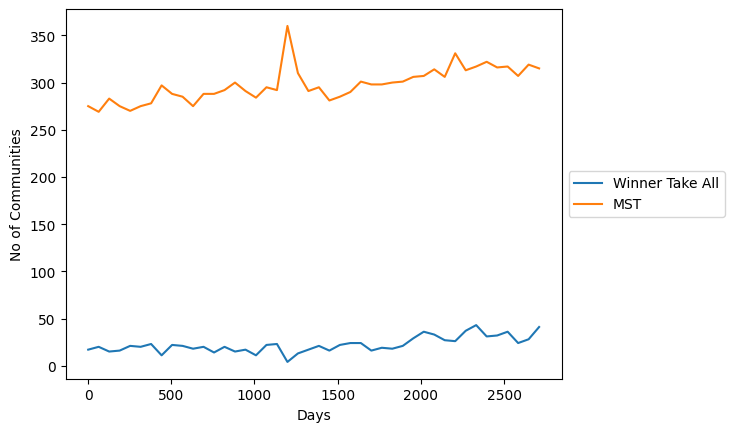

In [ ]:
# 5.5 Cell 34
import matplotlib.pyplot as plt
%matplotlib inline
cdf=attrib_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
cdf=attribMST_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.xlabel('Days')
plt.ylabel('No of Communities')
plt.show()

In [ ]:
# 5.6 Cell 35
cmatrix = attrib_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attrib_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
    jval[idxs] = [xlist,ylist]

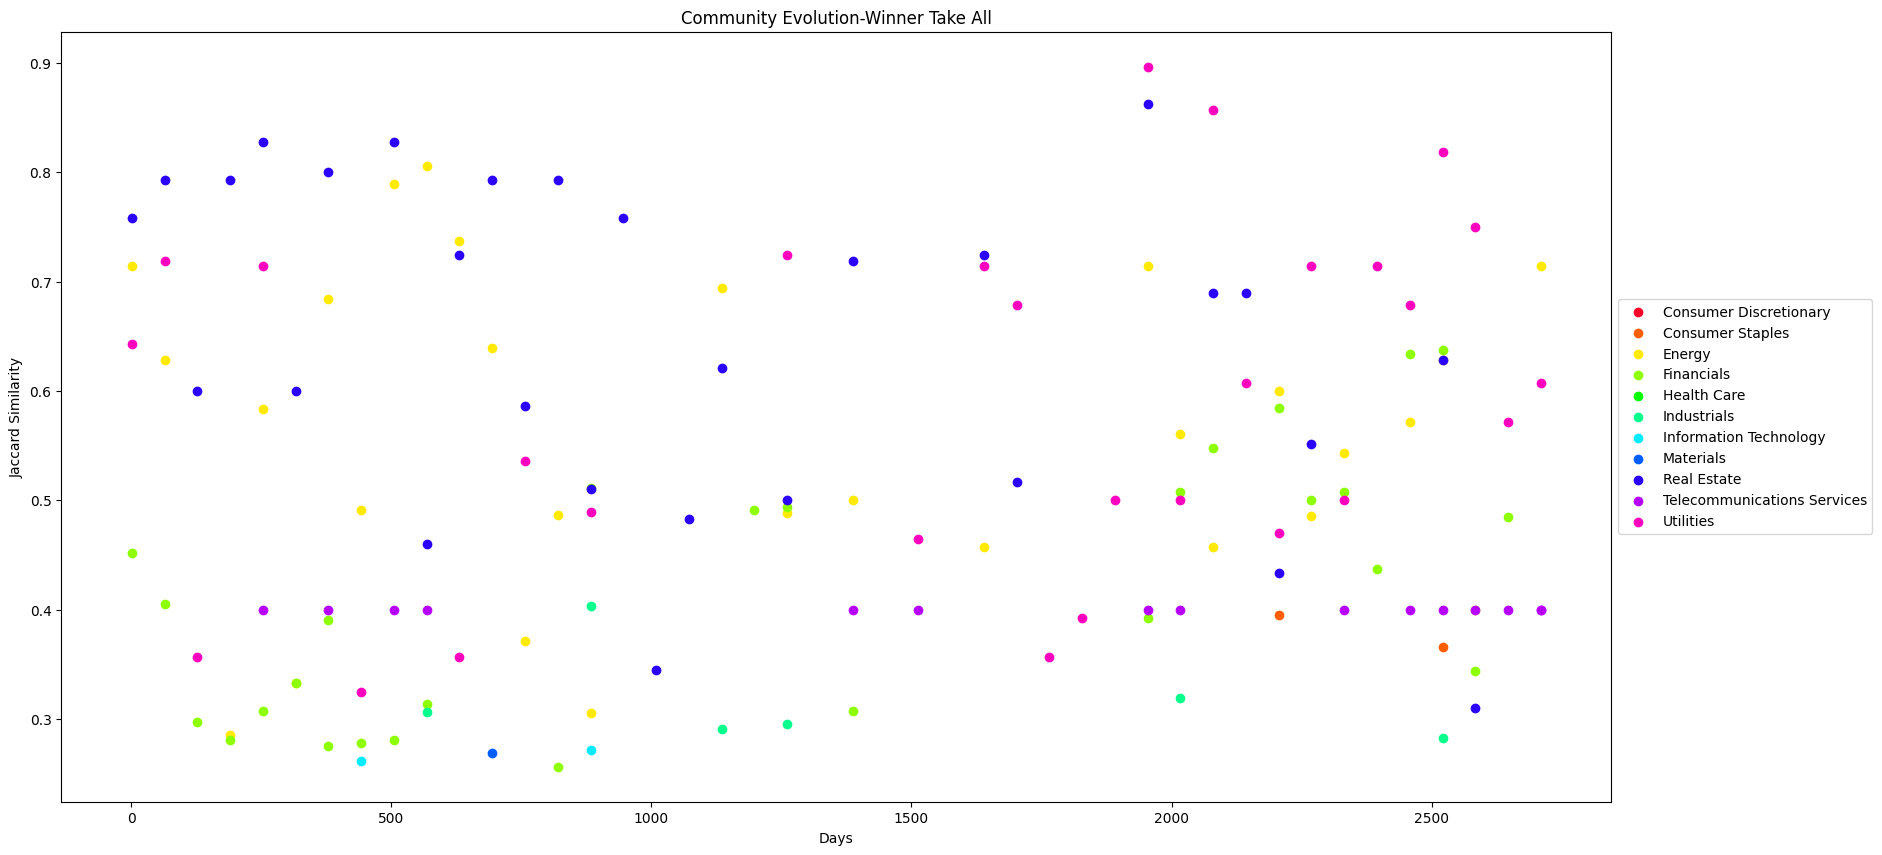

In [ ]:
# Cell 36 Community evolution visualization

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 11
colors = [cm(i) for i in np.linspace(0,1,NUM_COLORS)]
color_dict=dict(zip(list(jval.keys()), colors))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y,color=color_dict[key],label=key)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Similarity')
plt.title('Community Evolution-Winner Take All')
plt.show()

In [ ]:
# Cell 37 MST community analysis

cmatrix = attribMST_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attribMST_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
    jval[idxs] = [xlist,ylist]

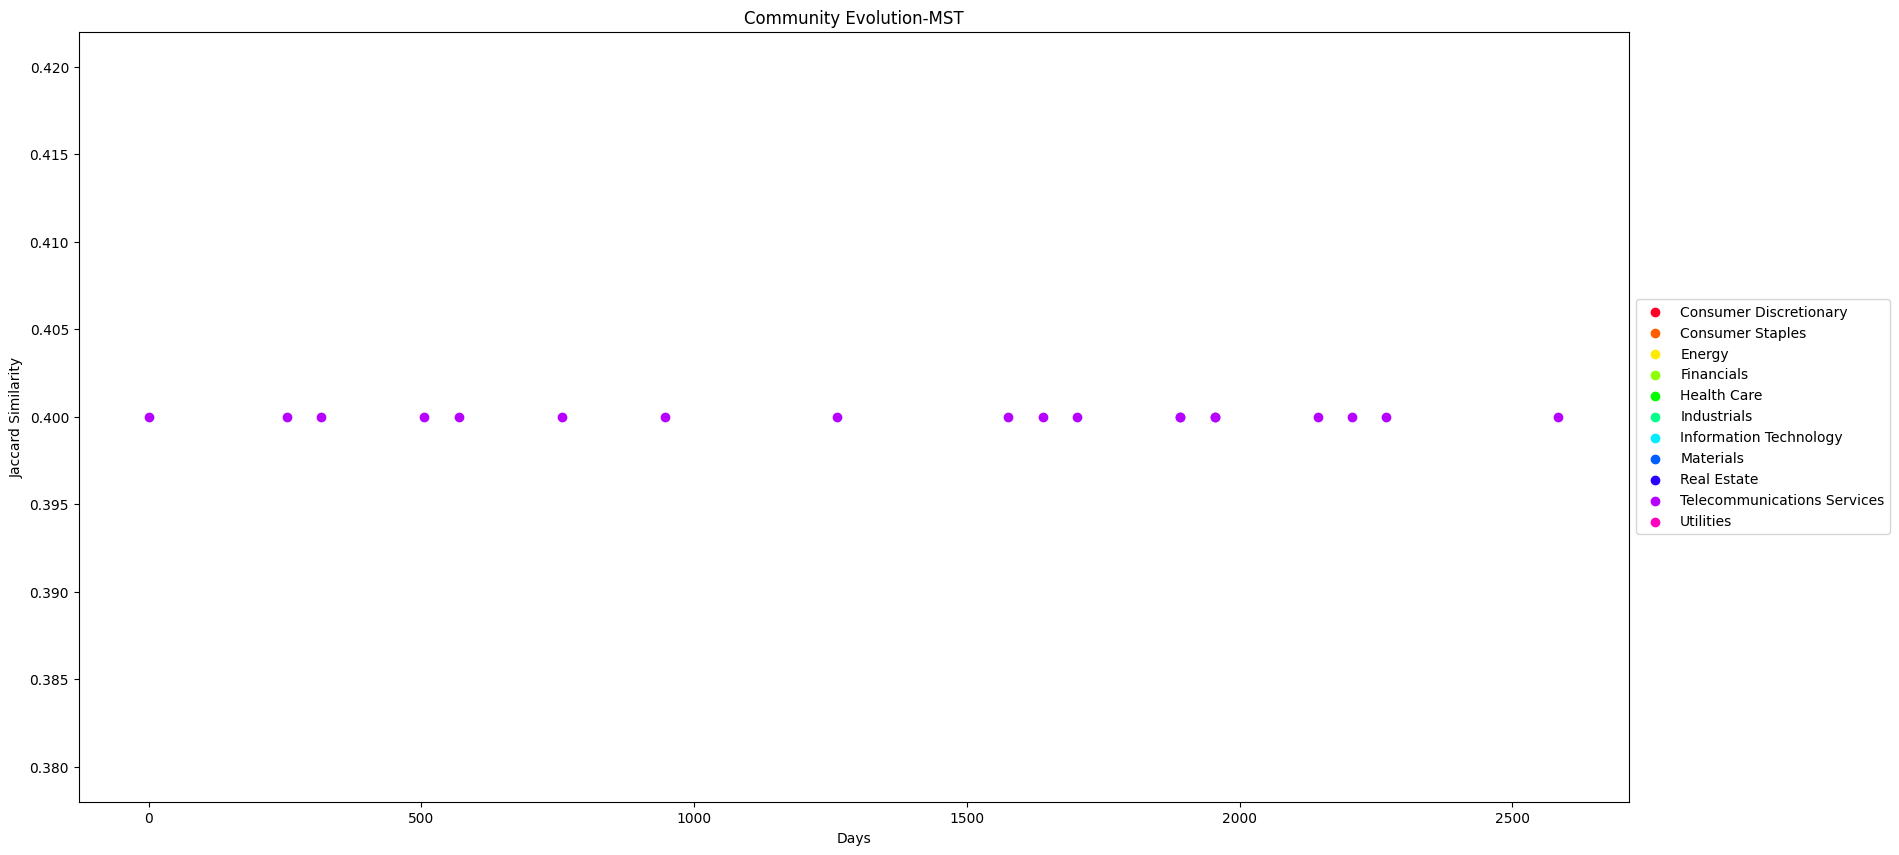

In [ ]:
# Cell 38 MST community visualization

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 11
colors = [cm(i) for i in np.linspace(0,1,NUM_COLORS)]
color_dict=dict(zip(list(jval.keys()), colors))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y,color=color_dict[key],label=key)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Similarity')
plt.title('Community Evolution-MST')
plt.show()

In [ ]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in G_dict.keys():
    M.add_nodes_from(G_dict[y].nodes(data=True))
    M.add_edges_from(G_dict[y].edges(data=True))
nx.write_gexf(M,'data/price-sp500.gexf')

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in G_dict.keys():
            T = G_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('data/price-sp500-o.gexf')

In [ ]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in GMST_dict.keys():
    M.add_nodes_from(GMST_dict[y].nodes(data=True))
    M.add_edges_from(GMST_dict[y].edges(data=True))
nx.write_gexf(M,'data/price-MST-sp500.gexf')

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-MST-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in GMST_dict.keys():
            T = GMST_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('data/price-MST-sp500-o.gexf')

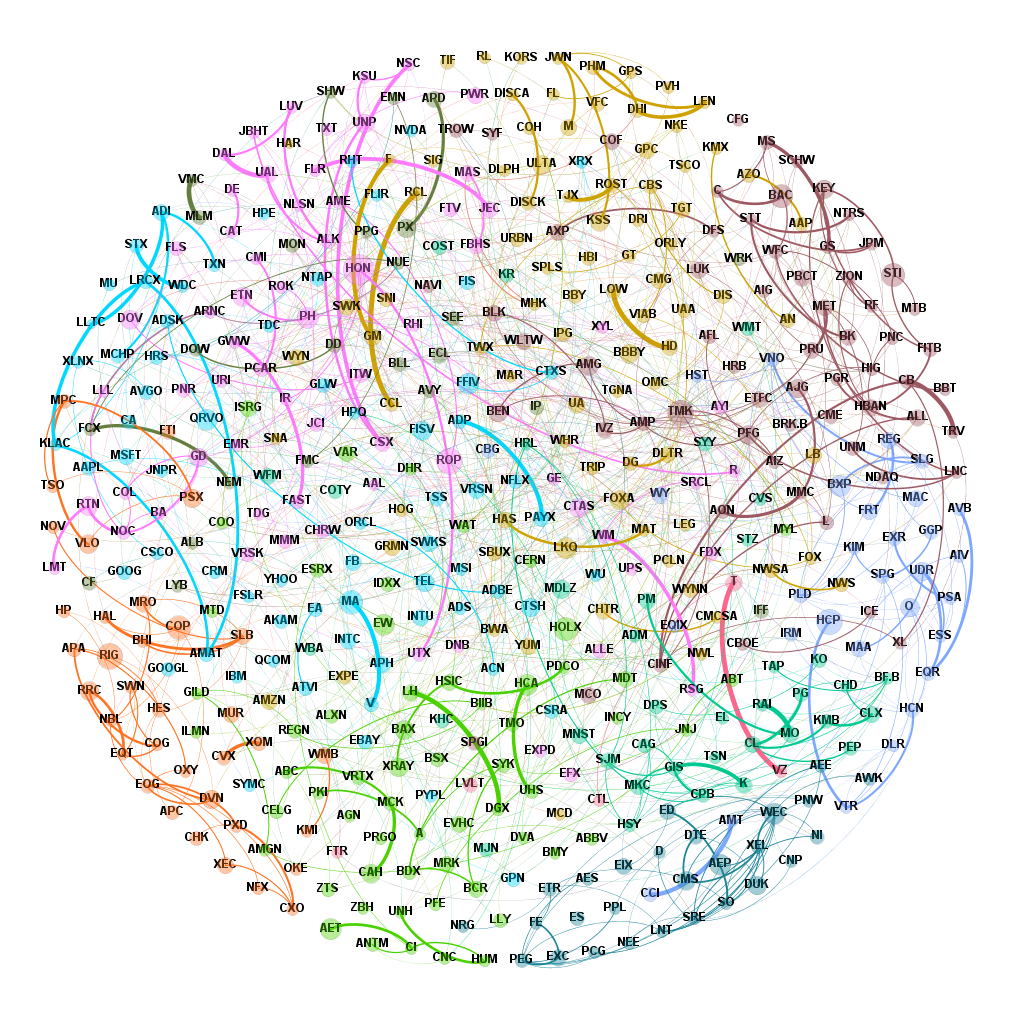

In [ ]:
from IPython.display import Image
Image(filename='data/MST-Period-1702.png') 

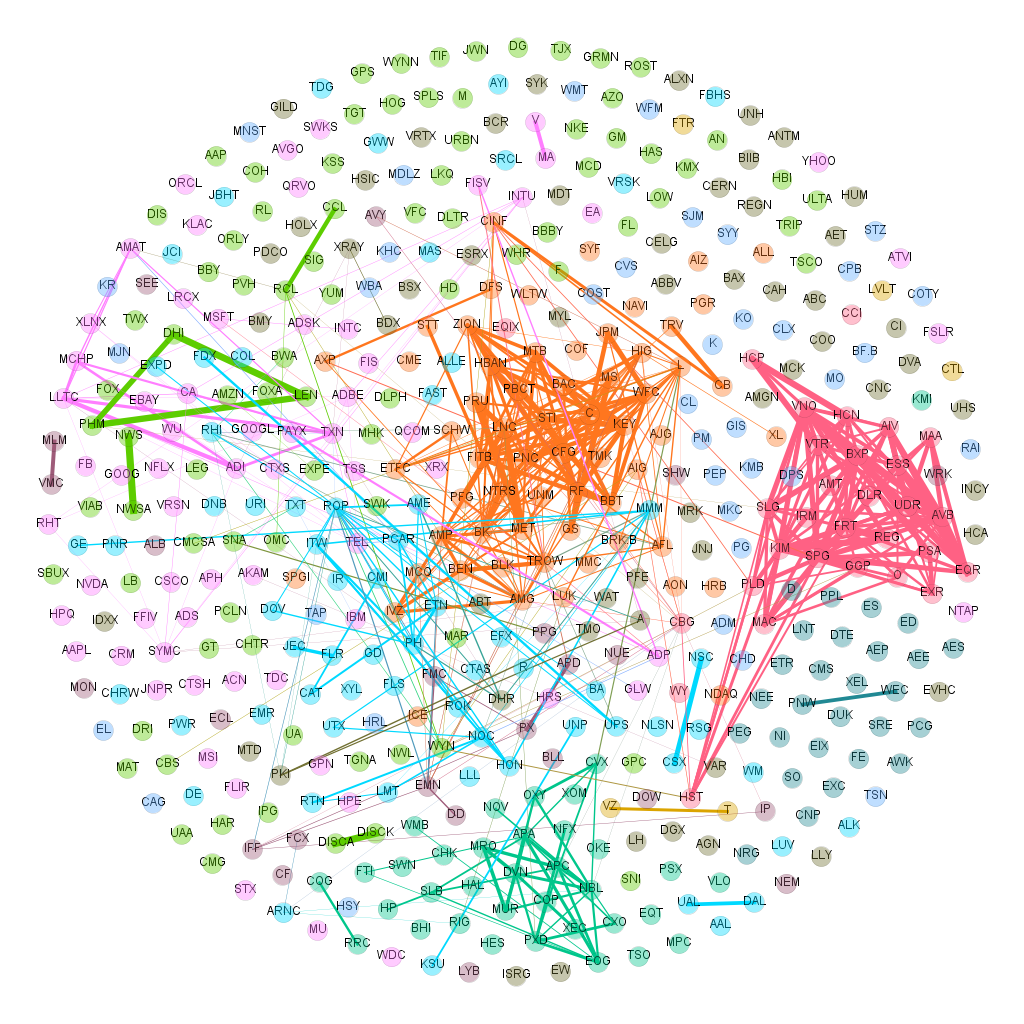

In [ ]:
from IPython.display import Image
Image(filename='data/WTA-period-1702.png') 

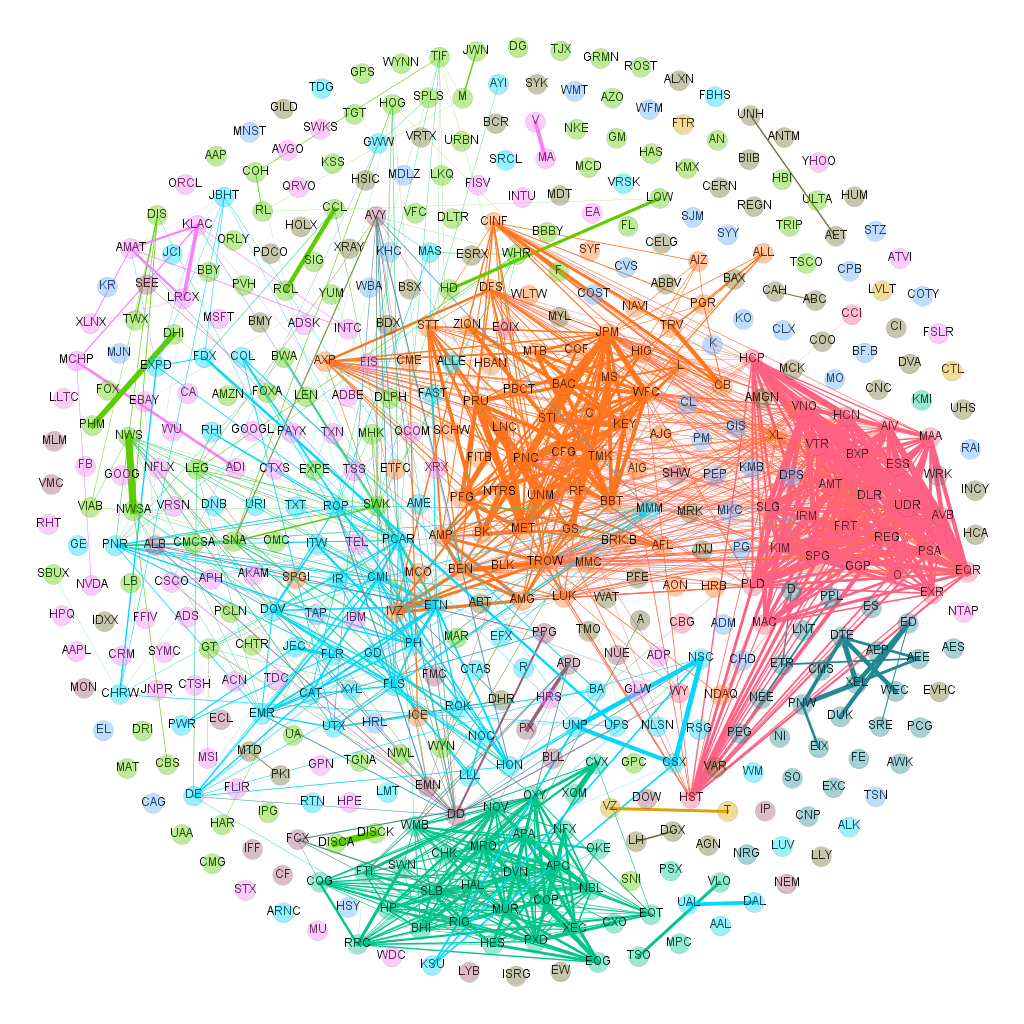

In [ ]:
from IPython.display import Image
Image(filename='data/WTA-period-568.png') 